# 1. Introduction
<p> This project introduces an intelligent, AI-powered ticket classification system. Using machine learning techniques, the system automates ticket categorization based on their content. This approach ensures tickets are accurately routed to the appropriate department or personnel, significantly reducing response times, minimizing errors, and improving overall customer satisfaction.

# 1. Importing Necessary Libraries and Packages

In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.3 MB/s eta 0:00:00


In [2]:
# Data Handling
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Natural Language Processing
import re
from sklearn.preprocessing import LabelEncoder
import spacy
import nltk
nltk.download('punkt_tab')
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import PorterStemmer
from contractions import fix

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

#Handling class imbalance
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

# Model Building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve,auc,precision_score,recall_score  # To evaluate model performance

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Topic Modeling
from sklearn.decomposition import NMF  # For Non-negative Matrix Factorization (NMF)

#Model Saving
import joblib

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2. Loading the Dataset

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/RaWseekQWERTY/Datasets/refs/heads/main/train-00000-of-00001.csv')

In [4]:
# Print the first 10 rows and variables
df.head(10)

Customer Email        Product Purchased           Ticket Type  \
0  carrollallison@example.com               gopro hero       technical issue   
1    clarkeashley@example.com              lg smart tv       technical issue   
2   gonzalestracy@example.com                 dell xps       technical issue   
3    bradleyolson@example.org         microsoft office       billing inquiry   
4     bradleymark@example.com         autodesk autocad       billing inquiry   
5     sheenasmith@example.com         microsoft office  cancellation request   
6     donaldkeith@example.org        microsoft surface       product inquiry   
7    joelwilliams@example.com       philips hue lights        refund request   
8        joshua24@example.com  fitbit versa smartwatch       technical issue   
9          clopez@example.com     dyson vacuum cleaner        refund request   

             Ticket Subject  \
0             product setup   
1  peripheral compatibility   
2           network problem   
3            account access   
4                 data loss   
5             payment issue   
6            refund request   
7              battery life   
8      installation support   
9             payment issue   

                                       Combined Text Ticket Priority  
0  i'm having an issue with the gopro hero. pleas...        critical  
1  i'm having an issue with the lg smart tv. plea...        critical  
2  i'm facing a problem with my dell xps. the del...             low  
3  i'm having an issue with the microsoft office....             low  
4  i'm having an issue with the autodesk autocad....             low  
5  i'm facing a problem with my microsoft office....             low  
6  i'm unable to access my microsoft surface acco...        critical  
7  i'm having an issue with the philips hue light...        critical  
8  i'm having an issue with the fitbit versa smar...             low  
9  my dyson vacuum cleaner is making strange nois...        critical

## 2.1. Data Understanding

In [5]:
df.shape # rows and columns

(8469, 6)

In [6]:
df.columns

Index(['Customer Email', 'Product Purchased', 'Ticket Type', 'Ticket Subject',
       'Combined Text', 'Ticket Priority'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Customer Email     8469 non-null   object
 1   Product Purchased  8469 non-null   object
 2   Ticket Type        8469 non-null   object
 3   Ticket Subject     8469 non-null   object
 4   Combined Text      8469 non-null   object
 5   Ticket Priority    8469 non-null   object
dtypes: object(6)
memory usage: 397.1+ KB


In [8]:
df.describe()

Customer Email Product Purchased     Ticket Type  Ticket Subject  \
count                 8469              8469            8469            8469   
unique                8320                42               5              16   
top     bsmith@example.com         canon eos  refund request  refund request   
freq                     4               240            1752             576   

                                            Combined Text Ticket Priority  
count                                                8469            8469  
unique                                               8438               4  
top     i'm having an issue with the google nest. plea...          medium  
freq                                                    3            2192

In [9]:
unique_ticket_types = df['Ticket Type'].unique()
unique_ticket_types

array(['technical issue', 'billing inquiry', 'cancellation request',
       'product inquiry', 'refund request'], dtype=object)

# 3.Data Preparation

## 3.1. Checking and Handling missing values

In [10]:
df.isnull().sum()

Customer Email       0
Product Purchased    0
Ticket Type          0
Ticket Subject       0
Combined Text        0
Ticket Priority      0
dtype: int64

As No null values are present which is a good thing so no need to drop them

## 3.2. Checking and Handling Duplicates Values

In [11]:
df.duplicated().sum()

0

No any duplicate values are present as well

# 4. EDA (Exploratory Data Analysis)

## 4.1. Univariate Non-Graphical Analysis

### 4.1.1 Text Variable Analysis

In [12]:
df['Combined Text'].describe()

count                                                  8469
unique                                                 8438
top       i'm having an issue with the google nest. plea...
freq                                                      3
Name: Combined Text, dtype: object

### 4.1.2. Ticket Type Variable Analysis

In [13]:
#summary statistics of the Class Variable
df['Ticket Type'].describe()

count               8469
unique                 5
top       refund request
freq                1752
Name: Ticket Type, dtype: object

In [14]:
# Checking unique values in the Ticket Type Variable
df['Ticket Type'].unique()

array(['technical issue', 'billing inquiry', 'cancellation request',
       'product inquiry', 'refund request'], dtype=object)

In [15]:
# Checking frequency distribution of the target variable
print("\nFrequency of each class in 'Ticket Type':")
print(df['Ticket Type'].value_counts())


Frequency of each class in 'Ticket Type':
Ticket Type
refund request          1752
technical issue         1747
cancellation request    1695
product inquiry         1641
billing inquiry         1634
Name: count, dtype: int64


## 4.2. Univariabte Graphical Analysis

### 4.2.1. Text Varibale Analysis

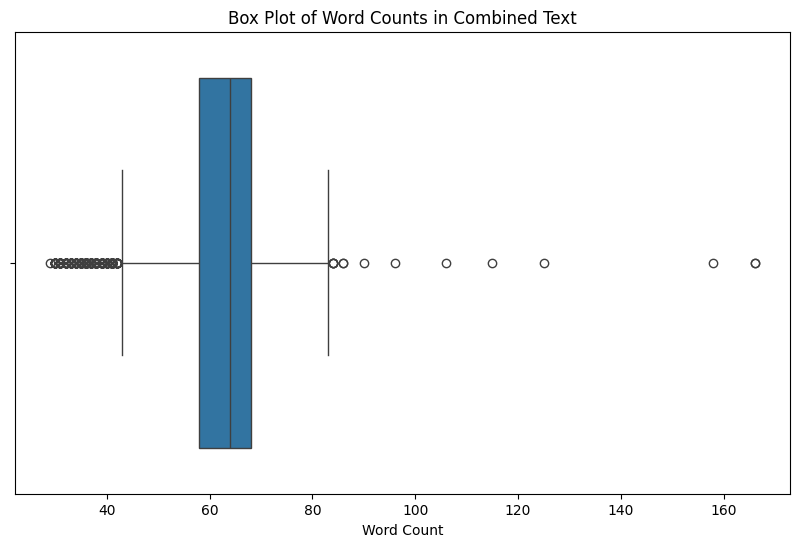

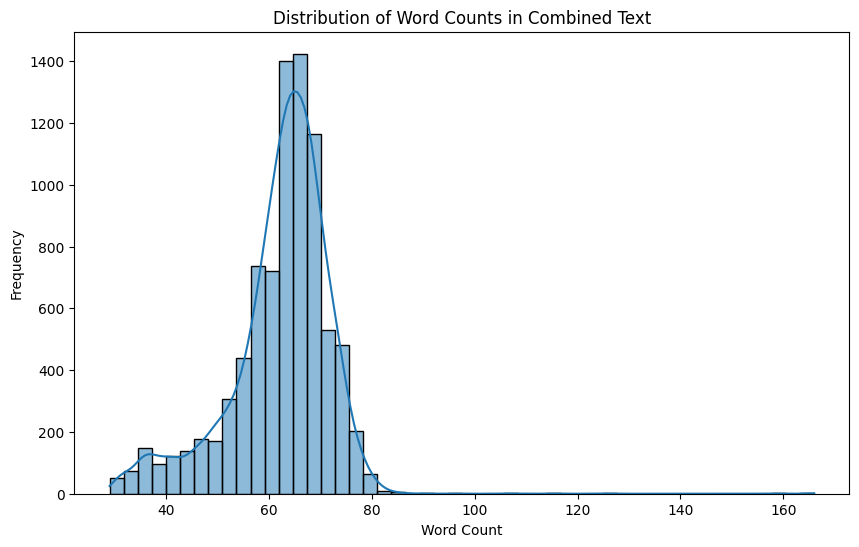

In [16]:
# Calculating word counts for each text
df['Word Count'] = df['Combined Text'].apply(lambda x: len(word_tokenize(str(x))))

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Word Count'])
plt.title('Box Plot of Word Counts in Combined Text')
plt.xlabel('Word Count')
plt.show()

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Word Count'], bins=50, kde=True)
plt.title('Distribution of Word Counts in Combined Text')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [17]:
df['Word Count'].skew()

-0.5593382793847481

In [18]:
df['Word Count'].describe()

count    8469.000000
mean       62.128941
std         9.758402
min        29.000000
25%        58.000000
50%        64.000000
75%        68.000000
max       166.000000
Name: Word Count, dtype: float64

In [19]:
# Word Count Greater Than the Boxplot's Upper Whisker
q3 = df['Word Count'].quantile(0.75)
iqr = q3 - df['Word Count'].quantile(0.25)
upper_whisker = q3 + 1.5 * iqr
outliers = df[df['Word Count'] > upper_whisker]

print("\nNumber of texts with word count greater than the upper whisker:", len(outliers))


Number of texts with word count greater than the upper whisker: 14


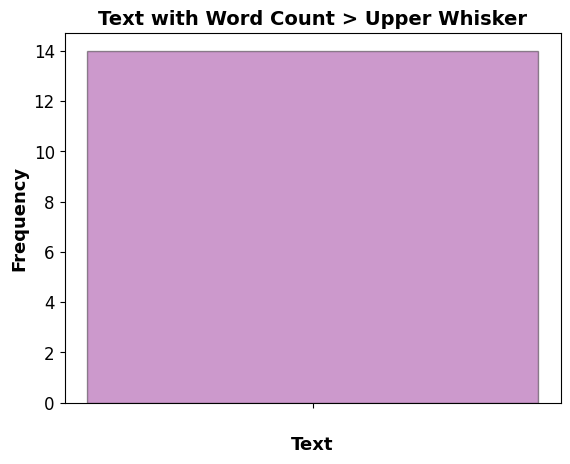

In [20]:
# Filter the dataset for text's word counts greater than the upper whisker
filtered_df = df[df['Word Count'] > upper_whisker]
# Count the number of rows
above_upper_whisker = filtered_df.shape[0]

# bar chart
bar = plt.bar(" ", above_upper_whisker, color = 'purple', alpha = 0.4, edgecolor = 'black')
plt.ylabel('Frequency', fontsize = 13, weight = 'bold')
plt.xlabel("Text", fontsize = 13, weight = 'bold')
plt.title("Text with Word Count > Upper Whisker", fontsize = 14, weight = 'bold')
plt.grid(False)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


plt.show()

In [21]:
print(outliers['Combined Text'].head())

1866    i'm facing issues logging into my sony 4k hdr ...
2914    i'm having an issue with the fitbit charge. pl...
3477    there seems to be a hardware problem with my n...
3652    i'm having an issue with the philips hue light...
4155    i'm having an issue with the microsoft office....
Name: Combined Text, dtype: object


In [22]:
# Word Count Greater Than the Boxplot's lower Whisker
q1 = df['Word Count'].quantile(0.25)
iqr = df['Word Count'].quantile(0.75) - q1
lower_whisker = q1 - 1.5 * iqr

outliers_lower = df[df['Word Count'] < lower_whisker]

print("\nNumber of texts with word count less than the lower whisker:", len(outliers_lower))


Number of texts with word count less than the lower whisker: 492


In [23]:
print(outliers_lower['Combined Text'].sample(10))

3293    i'm having an issue with the canon eos. please...
2919    i'm having an issue with the playstation. plea...
6091    i'm having an issue with the lg oled. please a...
2653    i'm having an issue with the nikon d. please a...
5578    i'm having an issue with the microsoft xbox co...
6923    i'm having an issue with the fitbit charge. pl...
802     i'm having an issue with the sony xperia. plea...
5008    i'm having an issue with the microsoft xbox co...
4551    i'm having an issue with the gopro hero. pleas...
5510    i'm having an issue with the canon dslr camera...
Name: Combined Text, dtype: object


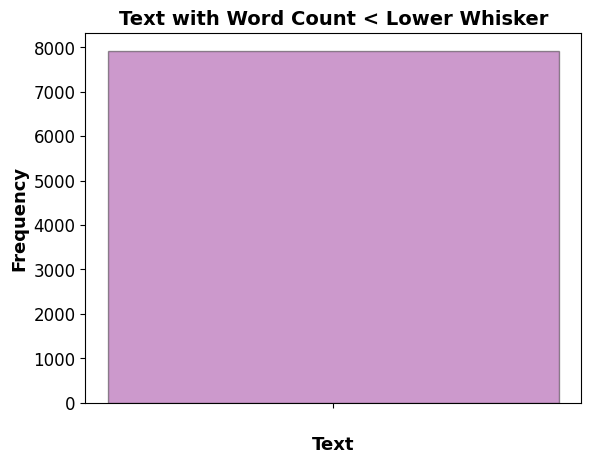

In [24]:
# Filter the dataset for text's word counts lower than the lower whisker
filtered_df = df[df['Word Count'] > lower_whisker]
# Count the number of rows
below_lower_whisker = filtered_df.shape[0]

#  bar chart
bar = plt.bar(" ", below_lower_whisker, color = 'purple', alpha = 0.4, edgecolor = 'black')
plt.ylabel('Frequency', fontsize = 13, weight = 'bold')
plt.xlabel("Text", fontsize = 13, weight = 'bold')
plt.title("Text with Word Count < Lower Whisker", fontsize = 14, weight = 'bold')
plt.grid(False)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


plt.show()

In [25]:
# df.drop('Word Count', inplace=True,axis=1)

### 4.2.2. Ticket Type Variable Analysis

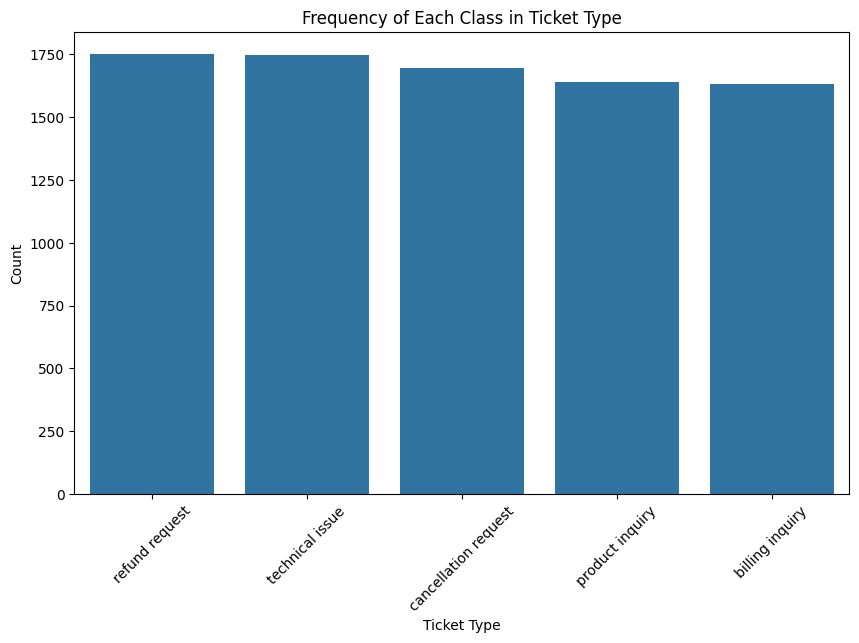

In [26]:
# Bar chart for class frequency
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Ticket Type', order=df['Ticket Type'].value_counts().index)
plt.title('Frequency of Each Class in Ticket Type')
plt.xlabel('Ticket Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 4.2.3. Stopwords Analysis


Top 20 Most Frequent Stopwords:
   Stopword  Frequency
4       the      26444
0         i      22500
15       to      10824
19       my       9611
16       it       8767
3      with       8344
2        an       7251
11        a       6825
1    having       6430
26      and       6014
6        is       5699
9       you       4782
13      but       4397
27     this       4364
21       on       3939
12       in       3359
29      for       3163
31       of       2769
46       be       2745
8      that       2647


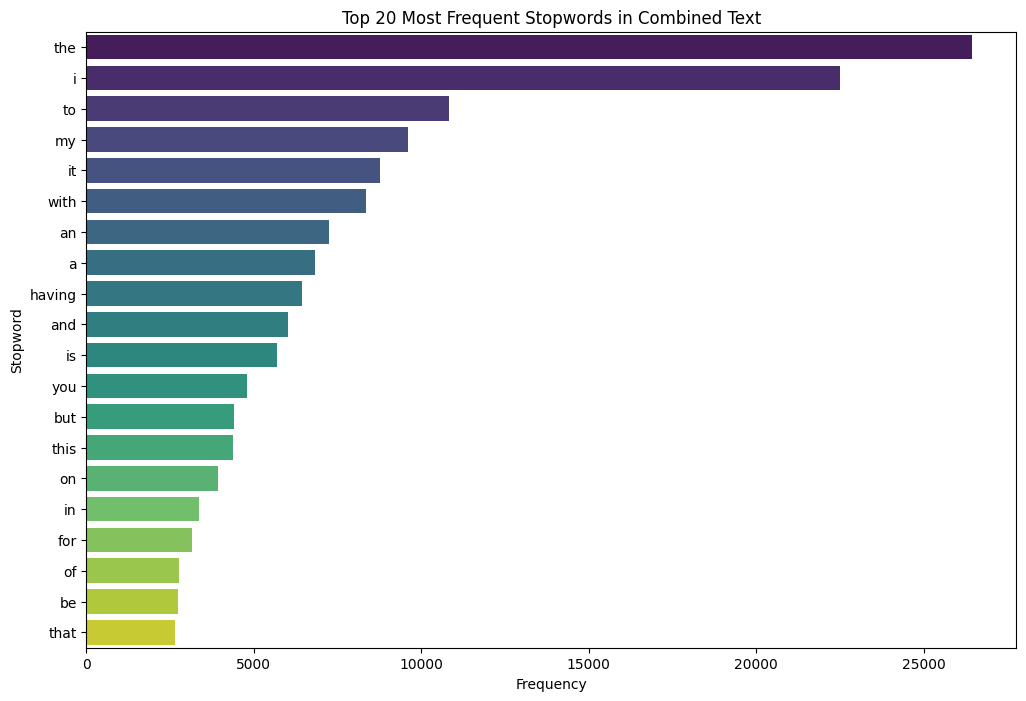

In [27]:
# Define English stopwords
stop_words = set(stopwords.words('english'))

# Tokenize the text and filter out stopwords
all_words = df['Combined Text'].dropna().apply(lambda x: word_tokenize(str(x).lower()))
stopword_list = [word for words in all_words for word in words if word in stop_words]

# Count the frequency of each stopword
stopword_freq = Counter(stopword_list)

# Convert to a DataFrame
stopword_df = pd.DataFrame(stopword_freq.items(), columns=['Stopword', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display the top 20 most frequent stopwords
print("\nTop 20 Most Frequent Stopwords:")
print(stopword_df.head(20))

# Plot the top 20 most frequent stopwords
plt.figure(figsize=(12, 8))
sns.barplot(data=stopword_df.head(20), x='Frequency', y='Stopword', palette='viridis')
plt.title('Top 20 Most Frequent Stopwords in Combined Text')
plt.xlabel('Frequency')
plt.ylabel('Stopword')
plt.show()


## 4.3. Bivariate Non-Graphical Analysis

### 4.3.1. Text and Ticket Type Analysis

In [28]:
# Function to extract top  n-grams
def get_top_ngrams(texts, n=1, top_n=10):
    vectorizer = TfidfVectorizer(ngram_range=(n, n), stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)

    # Sum up the TF-IDF scores for each word
    tfidf_sum = tfidf_matrix.sum(axis=0).A1
    tfidf_vocab = vectorizer.get_feature_names_out()

    # Create a dictionary of n-grams and their scores
    tfidf_scores = dict(zip(tfidf_vocab, tfidf_sum))

    # Sort and return the top n TF-IDF n-grams
    sorted_ngrams = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return sorted_ngrams

In [29]:
texts = df['Combined Text'].dropna().tolist()
# Top 10 unigrams
top_unigrams = get_top_ngrams(texts, n=1, top_n=10)
print("Top 10 Unigrams using TF-IDF:", top_unigrams)

# Top 10 bigrams
top_bigrams = get_top_ngrams(texts, n=2, top_n=10)
print("Top 10 Bigrams using TF-IDF:", top_bigrams)

# Top 10 trigrams
top_trigrams = get_top_ngrams(texts, n=3, top_n=10)
print("Top 10 Trigrams using TF-IDF:", top_trigrams)

Top 10 Unigrams using TF-IDF: [('issue', 538.6403813463054), ('having', 361.3195649854676), ('ve', 360.8717656072542), ('assist', 360.0166823524134), ('resolution', 347.3310288474795), ('pending', 347.20409292801685), ('product', 244.60461189864805), ('problem', 228.76069546965178), ('account', 197.0865234748877), ('data', 186.83706238918808)]
Top 10 Bigrams using TF-IDF: [('having issue', 263.458908953887), ('resolution pending', 260.79347359268434), ('issue persists', 108.92521025139875), ('ve noticed', 104.70024908924331), ('ve tried', 94.4482178412731), ('persists resolution', 87.75742756706558), ('ve checked', 79.75573540136527), ('resolve problem', 78.30439621249876), ('troubleshooting steps', 78.25706530462034), ('nintendo switch', 75.96062901544161)]
Top 10 Trigrams using TF-IDF: [('issue persists resolution', 79.39031926277349), ('persists resolution pending', 79.39031926277349), ('productivity resolution pending', 59.253680305256445), ('affecting work productivity', 57.499746

## 4.4. Bivariate Graphical Analysis

### 4.4.1. Word Cloud for each Ticket Type

In [30]:
# Function to generate a Word Cloud for each class
def generate_wordcloud(class_name):
    text = " ".join(df[df['Ticket Type'] == class_name]['Combined Text'].dropna().tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {class_name}', fontsize=16)
    plt.axis('off')
    plt.show()


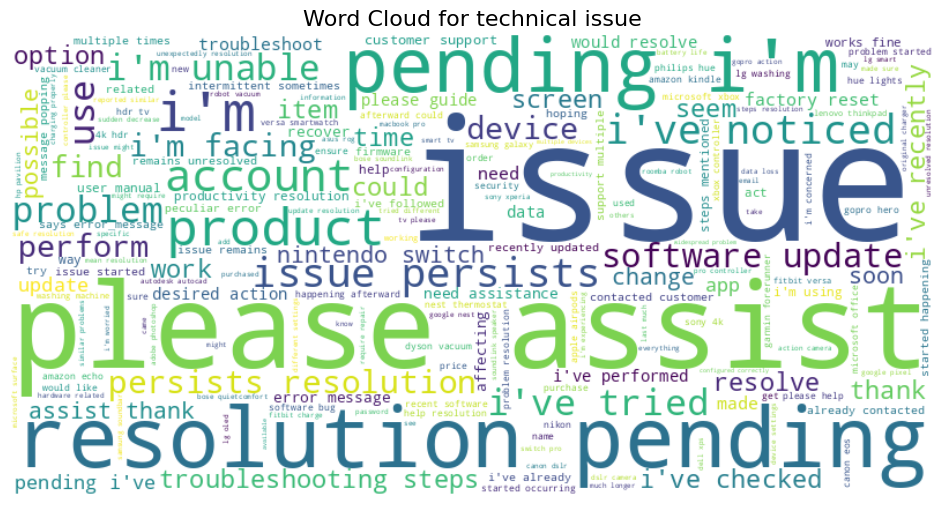

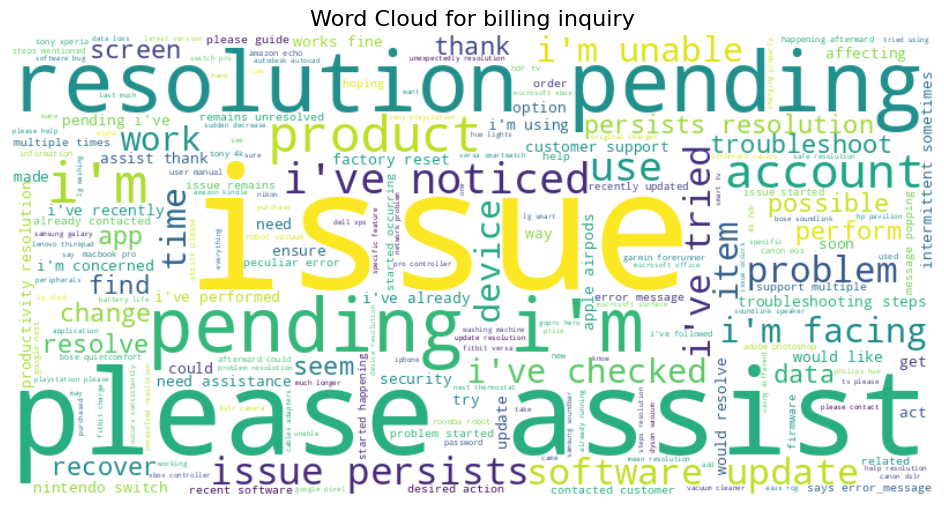

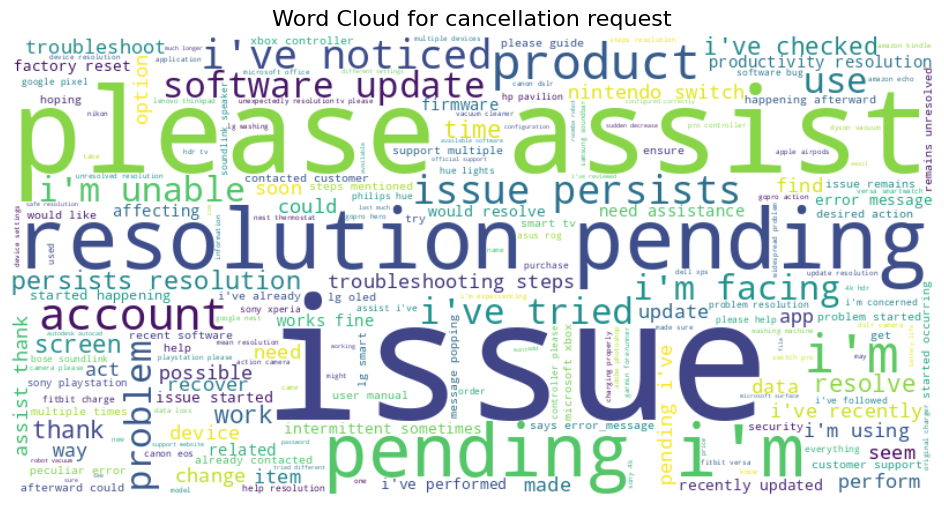

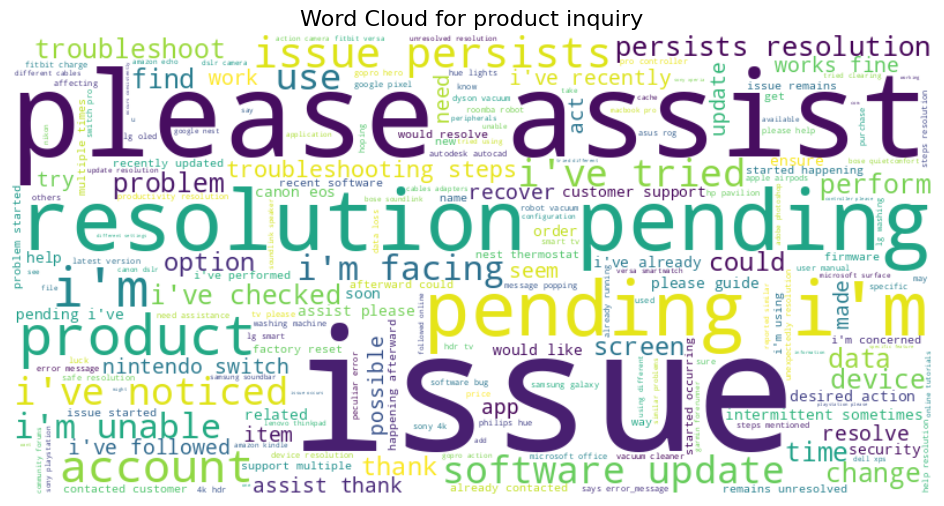

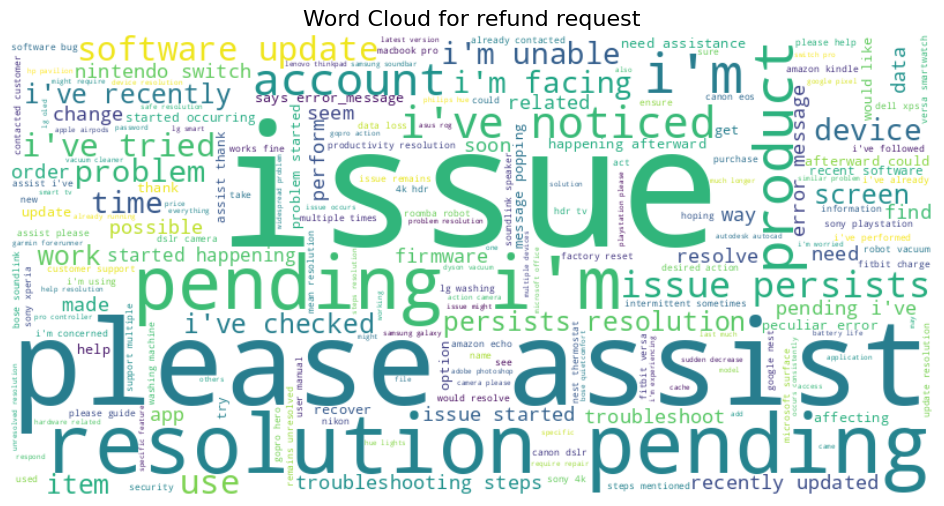

In [31]:
# Generate Word Cloud for each class
classes = df['Ticket Type'].unique()
for class_name in classes:
    generate_wordcloud(class_name)

### 4.4.2.  Density of Word Count Length in Text by Class

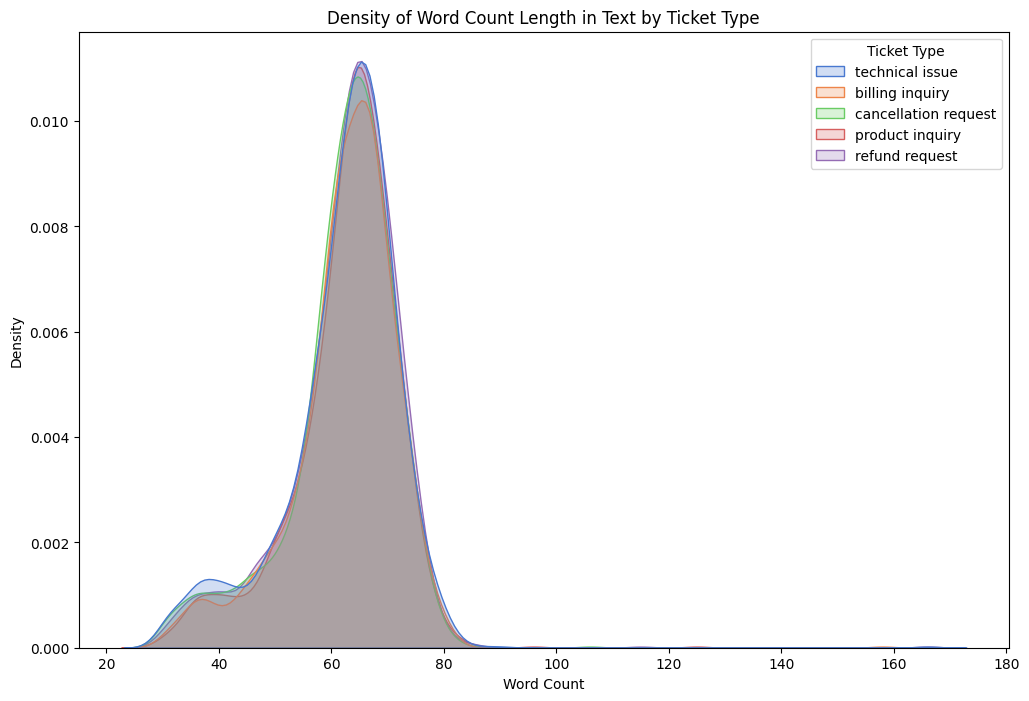

In [32]:
# Density Plot of Word Count by Class
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='Word Count', hue='Ticket Type', fill=True, palette='muted')
plt.title('Density of Word Count Length in Text by Ticket Type')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.show()


### 4.4.3. Frequency of Top 20 Unigrams, Bigrams, and Trigrams for Each Class

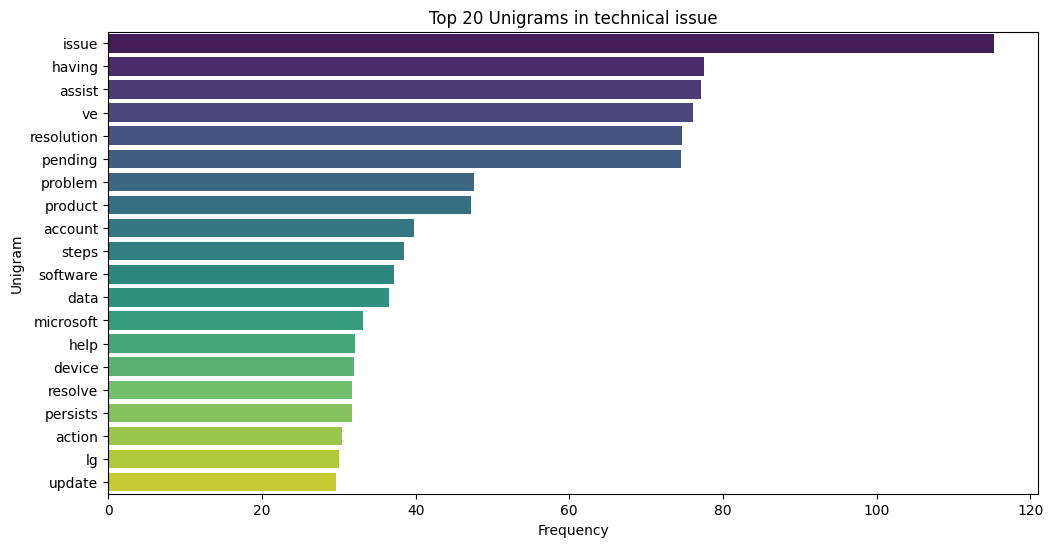

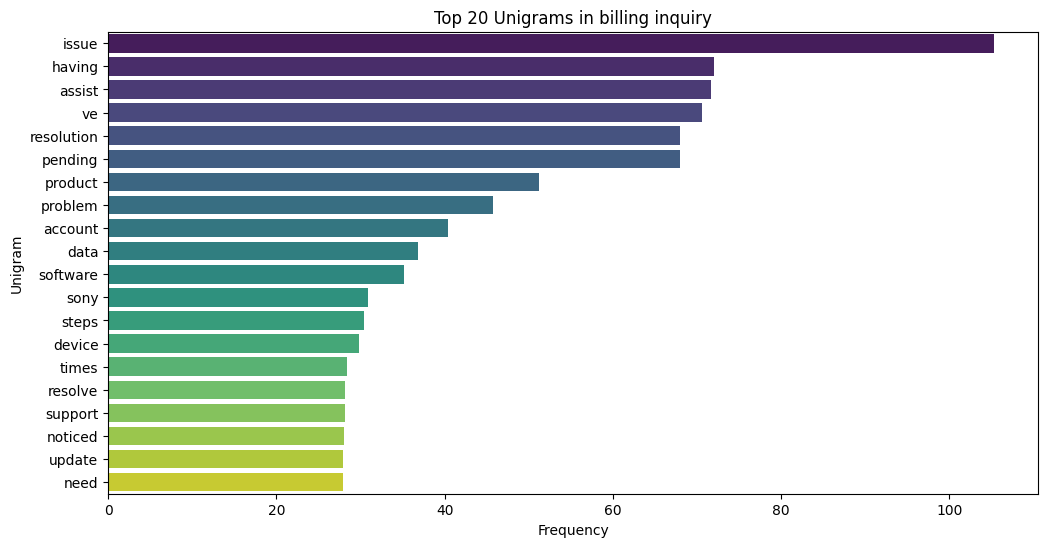

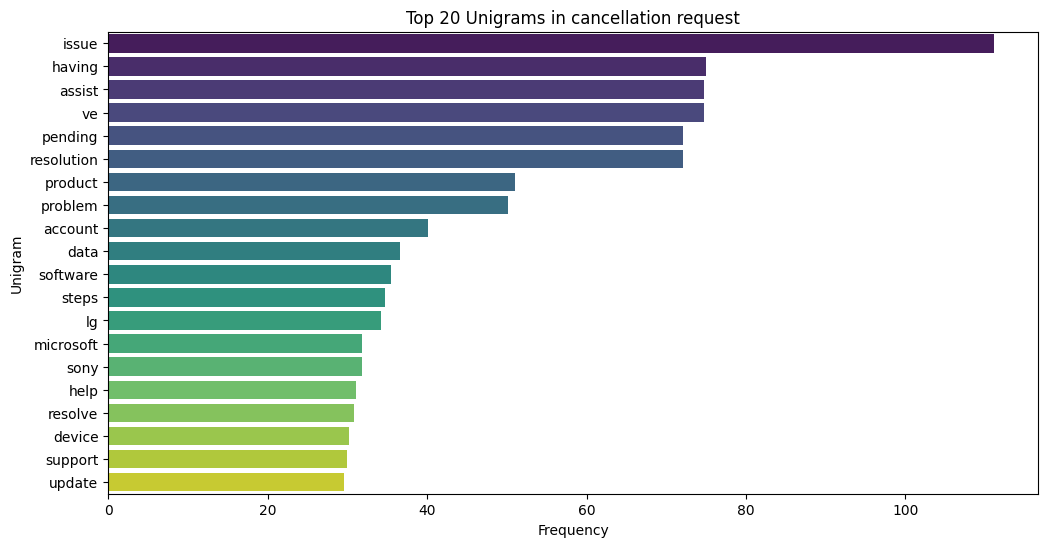

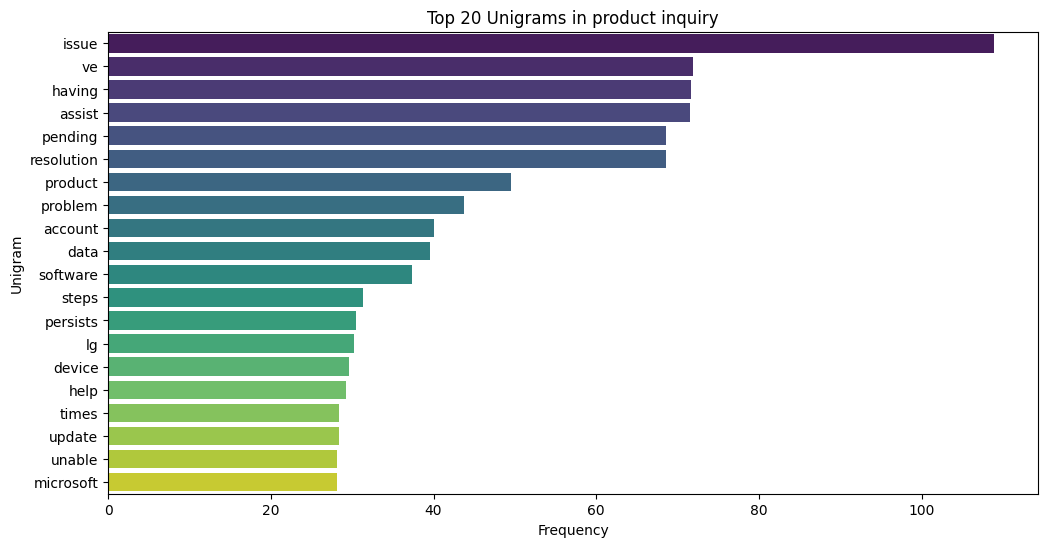

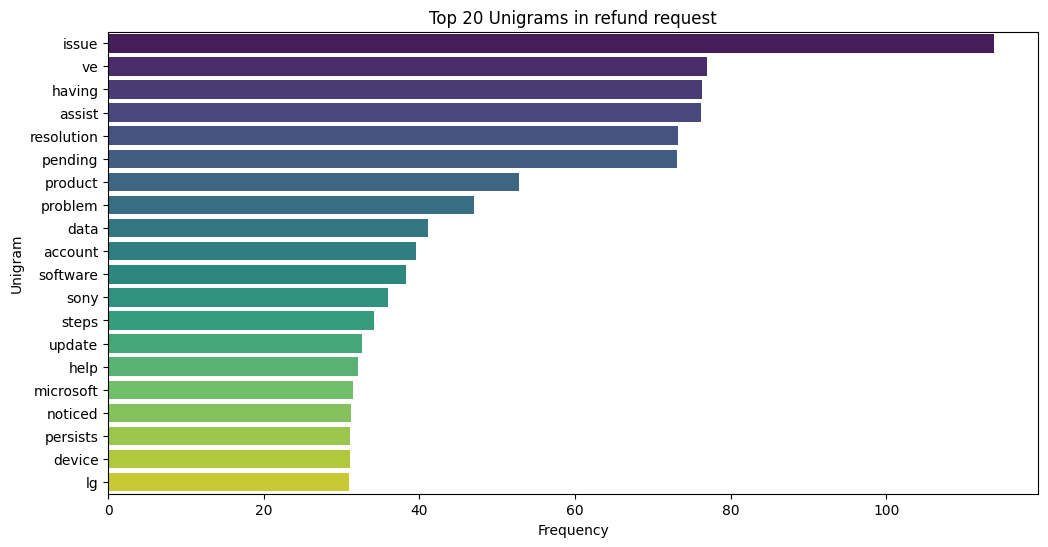

In [33]:
# Frequency of Top 20 Unigrams in Each Ticket Type
for class_name in classes:
    class_texts = df[df['Ticket Type'] == class_name]['Combined Text'].dropna().tolist()
    top_unigrams = get_top_ngrams(class_texts, n=1, top_n=20)

    unigram_df = pd.DataFrame(top_unigrams, columns=['Unigram', 'Frequency'])

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(data=unigram_df, x='Frequency', y='Unigram', palette='viridis')
    plt.title(f'Top 20 Unigrams in {class_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Unigram')
    plt.show()


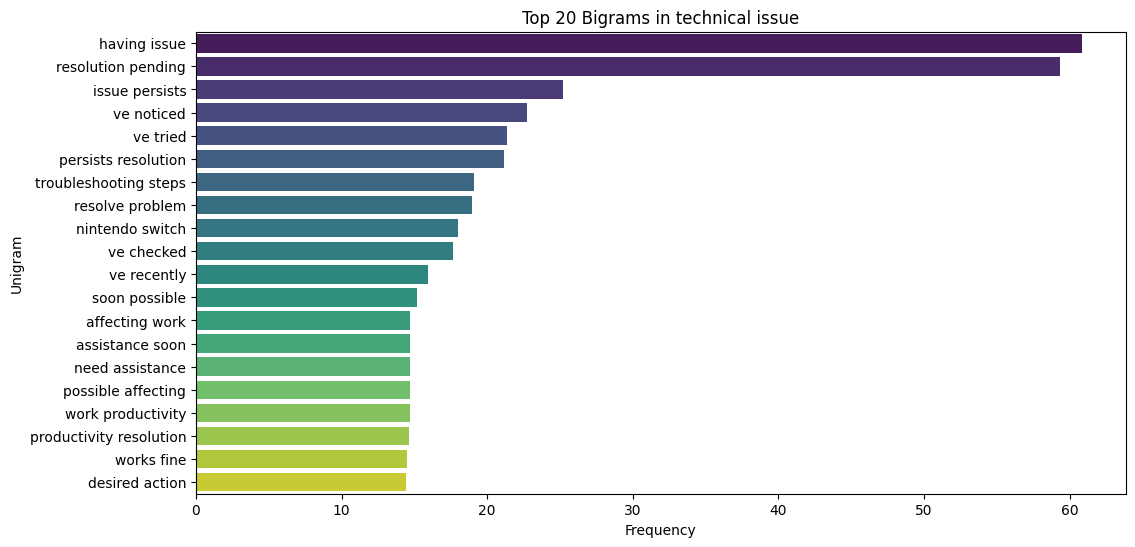

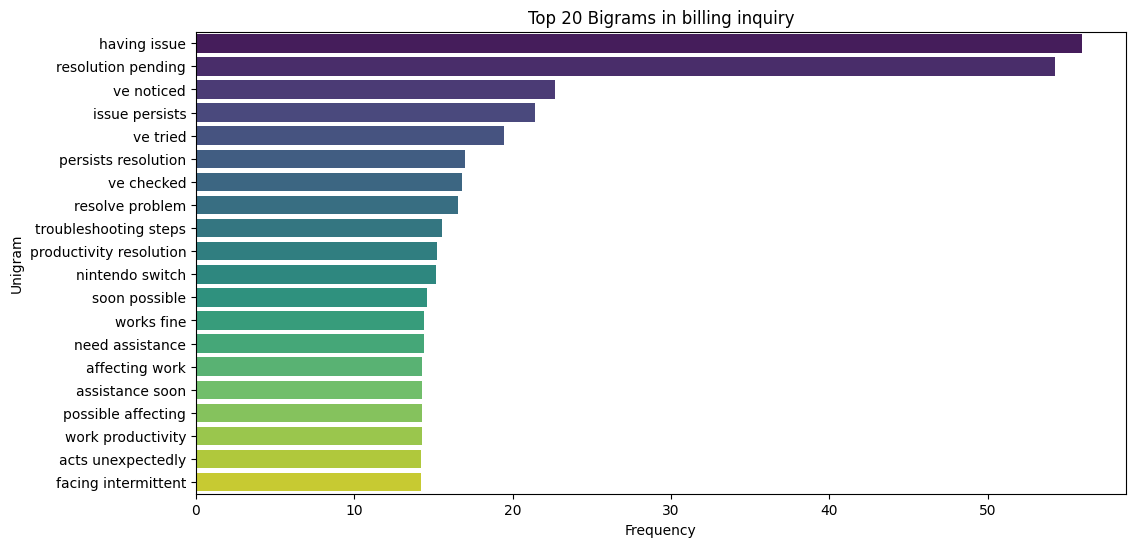

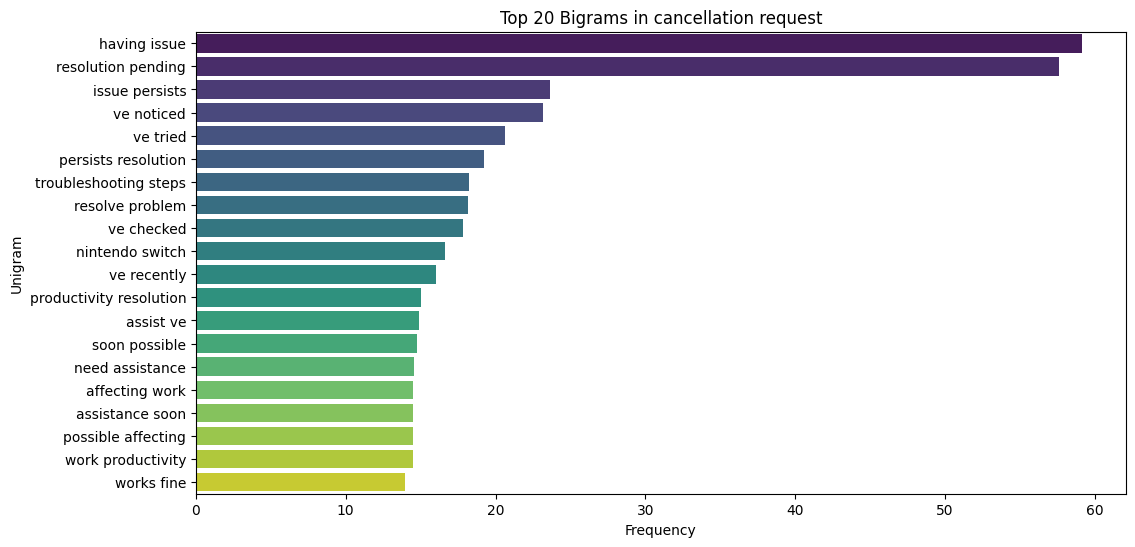

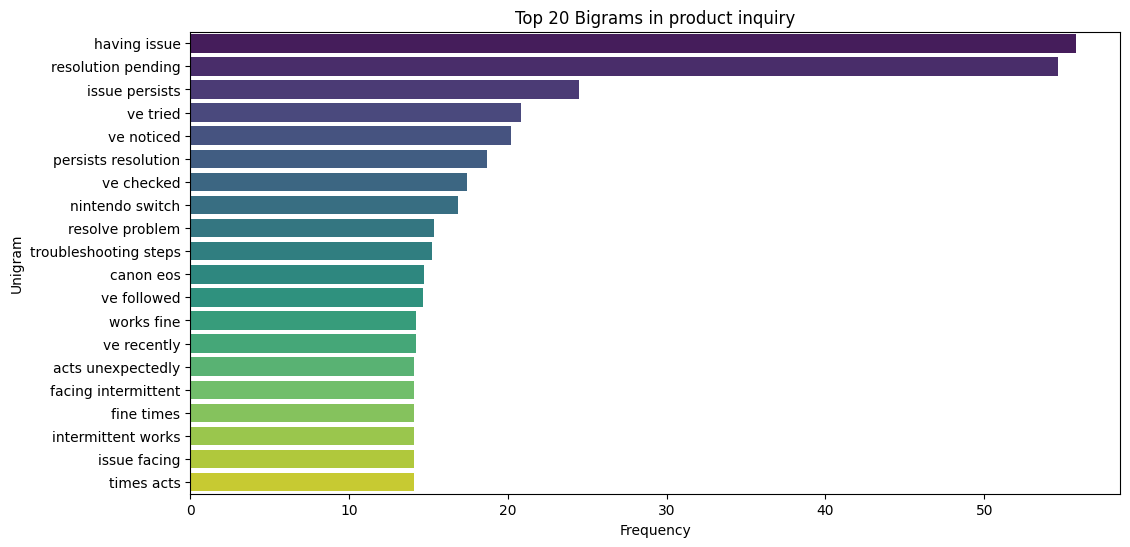

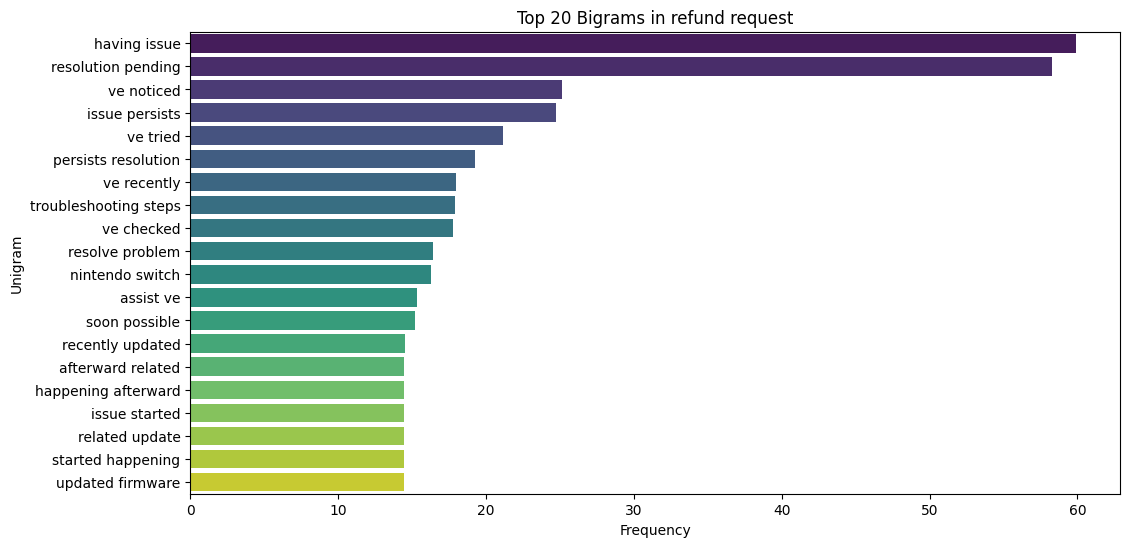

In [34]:
# Frequency of Top 20 Bigrams in Each Ticket Type
for class_name in classes:
    class_texts = df[df['Ticket Type'] == class_name]['Combined Text'].dropna().tolist()
    top_unigrams = get_top_ngrams(class_texts, n=2, top_n=20)

    Bigram_df = pd.DataFrame(top_unigrams, columns=['Bigram', 'Frequency'])

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(data=Bigram_df, x='Frequency', y='Bigram', palette='viridis')
    plt.title(f'Top 20 Bigrams in {class_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Unigram')
    plt.show()

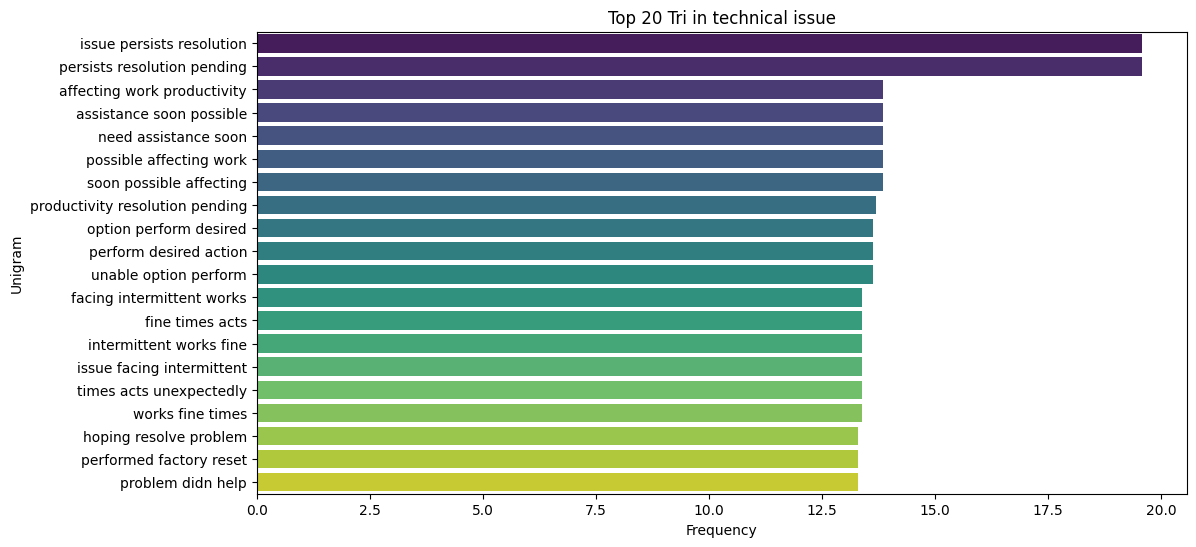

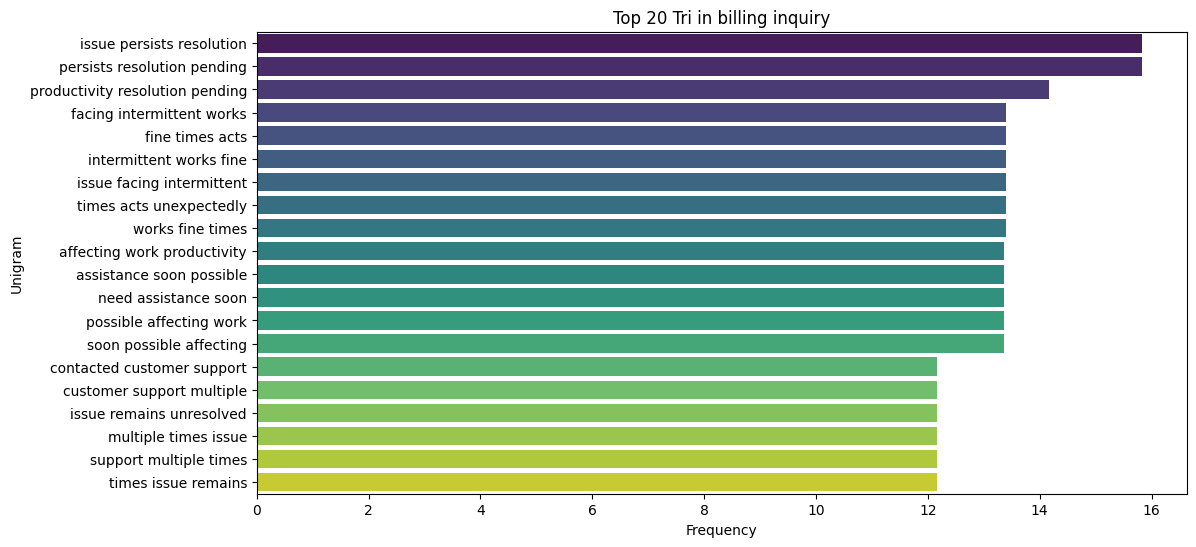

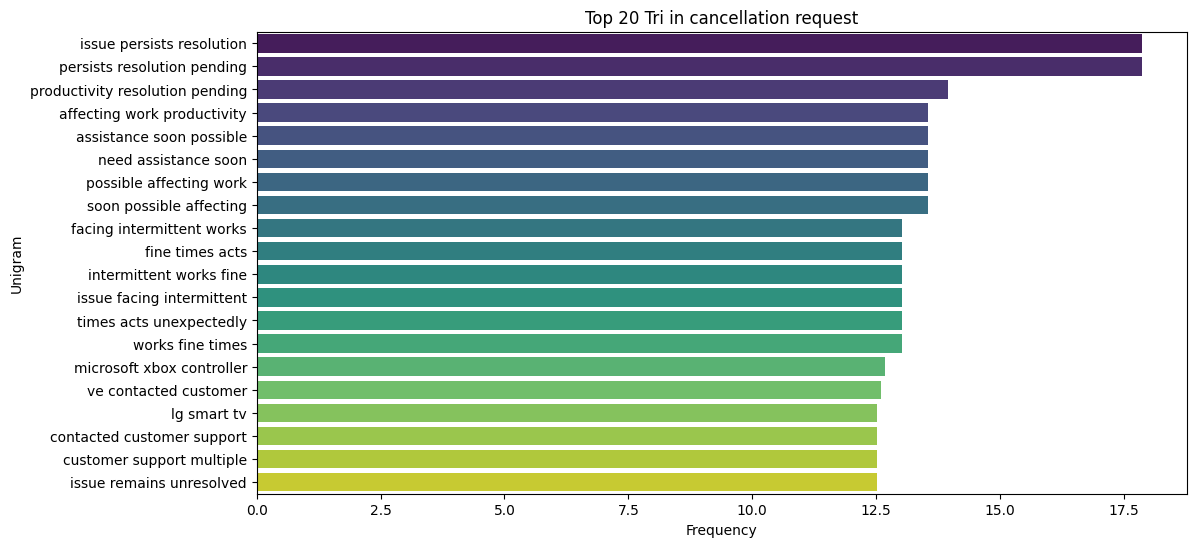

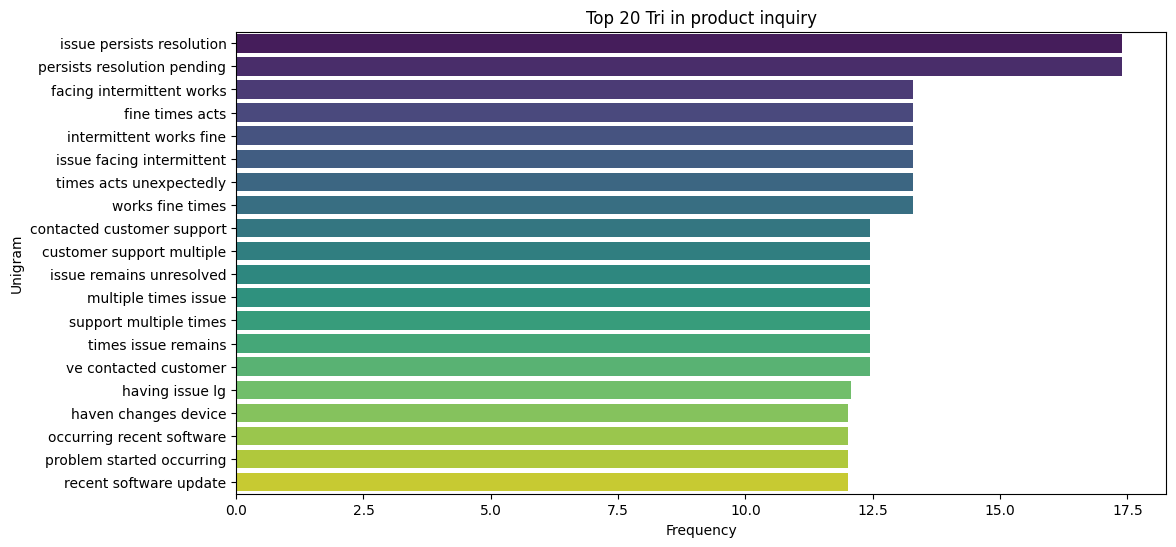

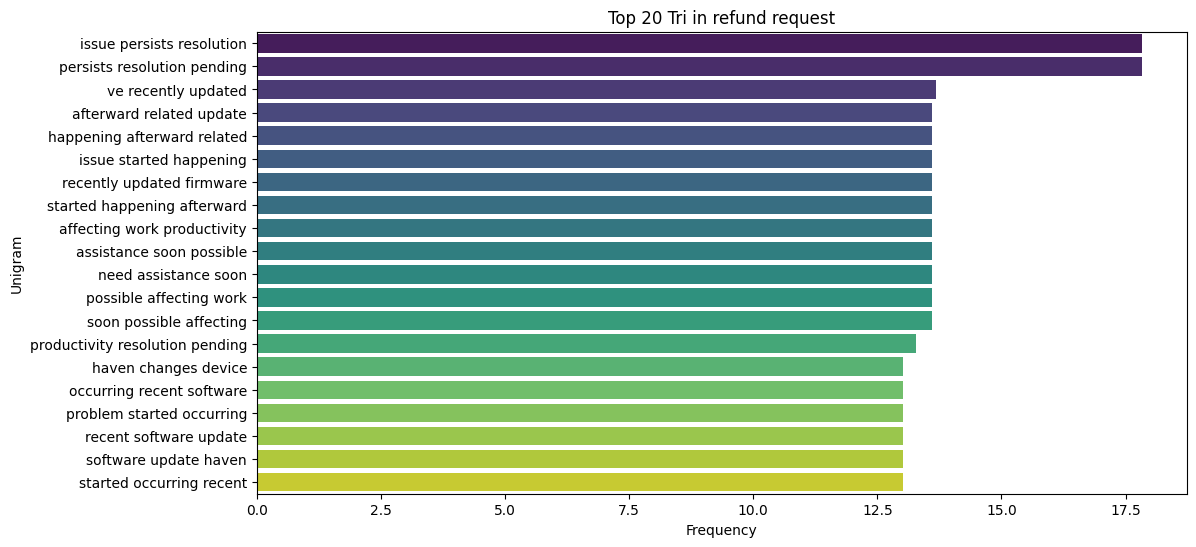

In [35]:
# Frequency of Top 20 Trigrams in Each Ticket Type
for class_name in classes:
    class_texts = df[df['Ticket Type'] == class_name]['Combined Text'].dropna().tolist()
    top_unigrams = get_top_ngrams(class_texts, n=3, top_n=20)

    trigram_df = pd.DataFrame(top_unigrams, columns=['trigram', 'Frequency'])

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(data=trigram_df, x='Frequency', y='trigram', palette='viridis')
    plt.title(f'Top 20 Tri in {class_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Unigram')
    plt.show()

# 5. Text Preprocessing

## 5.1. Cleaning Data

In [36]:
# Cleaning function to make text lowercase, remove punctuation, numbers, and text in brackets
def clean_text(text):
    # Make the text lowercase
    text = text.lower()
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    return text


In [37]:
df['Cleaned Text'] = df['Combined Text'].apply(clean_text)


In [38]:
df[['Combined Text', 'Cleaned Text']].head()

Combined Text  \
0  i'm having an issue with the gopro hero. pleas...   
1  i'm having an issue with the lg smart tv. plea...   
2  i'm facing a problem with my dell xps. the del...   
3  i'm having an issue with the microsoft office....   
4  i'm having an issue with the autodesk autocad....   

                                        Cleaned Text  
0  im having an issue with the gopro hero please ...  
1  im having an issue with the lg smart tv please...  
2  im facing a problem with my dell xps the dell ...  
3  im having an issue with the microsoft office p...  
4  im having an issue with the autodesk autocad p...

## 5.2. Tokenization

<p>Tokenization splits the text into individual words (tokens).

In [39]:
# Tokenize the Cleaned Text column
df['Tokenized Text'] = df['Cleaned Text'].apply(word_tokenize)

In [40]:
df[['Cleaned Text', 'Tokenized Text']].head()

Cleaned Text  \
0  im having an issue with the gopro hero please ...   
1  im having an issue with the lg smart tv please...   
2  im facing a problem with my dell xps the dell ...   
3  im having an issue with the microsoft office p...   
4  im having an issue with the autodesk autocad p...   

                                      Tokenized Text  
0  [im, having, an, issue, with, the, gopro, hero...  
1  [im, having, an, issue, with, the, lg, smart, ...  
2  [im, facing, a, problem, with, my, dell, xps, ...  
3  [im, having, an, issue, with, the, microsoft, ...  
4  [im, having, an, issue, with, the, autodesk, a...

## 5.3. Stop Words Removal

<p>Stop words are commonly used words (like "the", "is", "and") that don't add much meaning to the text.

In [41]:
# Get the list of English stop words
stop_words = set(stopwords.words('english'))
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]

In [42]:
df['Text Without Stop Words'] = df['Tokenized Text'].apply(remove_stop_words)

In [43]:
print(df[['Tokenized Text', 'Text Without Stop Words']].head())

                                      Tokenized Text  \
0  [im, having, an, issue, with, the, gopro, hero...   
1  [im, having, an, issue, with, the, lg, smart, ...   
2  [im, facing, a, problem, with, my, dell, xps, ...   
3  [im, having, an, issue, with, the, microsoft, ...   
4  [im, having, an, issue, with, the, autodesk, a...   

                             Text Without Stop Words  
0  [im, issue, gopro, hero, please, assist, billi...  
1  [im, issue, lg, smart, tv, please, assist, nee...  
2  [im, facing, problem, dell, xps, dell, xps, tu...  
3  [im, issue, microsoft, office, please, assist,...  
4  [im, issue, autodesk, autocad, please, assist,...  


## 5.4. Stemming and Lemmatization

<li> Stemming reduces words to their root form by chopping off suffixes (e.g., "running" → "run").
<li>Lemmatization returns the base or dictionary form of a word (e.g., "better" → "good").

### 5.4.1. Stemming

In [44]:
# Initialize the stemmer
stemmer = PorterStemmer()

def stem_words(tokens):
    return [stemmer.stem(word) for word in tokens]

In [45]:
df['Stemmed Text'] = df['Text Without Stop Words'].apply(stem_words)

In [46]:
df[['Text Without Stop Words', 'Stemmed Text']].head()

Text Without Stop Words  \
0  [im, issue, gopro, hero, please, assist, billi...   
1  [im, issue, lg, smart, tv, please, assist, nee...   
2  [im, facing, problem, dell, xps, dell, xps, tu...   
3  [im, issue, microsoft, office, please, assist,...   
4  [im, issue, autodesk, autocad, please, assist,...   

                                        Stemmed Text  
0  [im, issu, gopro, hero, pleas, assist, bill, z...  
1  [im, issu, lg, smart, tv, pleas, assist, need,...  
2  [im, face, problem, dell, xp, dell, xp, turn, ...  
3  [im, issu, microsoft, offic, pleas, assist, pr...  
4  [im, issu, autodesk, autocad, pleas, assist, n...

### 5.4.2. Lemmatization

In [47]:
# Load the SpaCy model (English)
nlp = spacy.load('en_core_web_sm')

In [48]:
def lemmatize_text(tokens):
    doc = nlp(' '.join(tokens))
    return [token.lemma_ for token in doc]

In [49]:
df['Lemmatized Text'] = df['Text Without Stop Words'].apply(lemmatize_text)

## 5.5. Handling Contractions
Contractions (e.g., "don't", "can't") need to be expanded to improve text understanding.

In [50]:
def expand_contractions(text):
    return fix(text)

In [51]:
# Apply contraction handling to the Combined Text column
df['Expanded Text'] = df['Combined Text'].apply(expand_contractions)

In [52]:
df[['Combined Text', 'Expanded Text']].head()

Combined Text  \
0  i'm having an issue with the gopro hero. pleas...   
1  i'm having an issue with the lg smart tv. plea...   
2  i'm facing a problem with my dell xps. the del...   
3  i'm having an issue with the microsoft office....   
4  i'm having an issue with the autodesk autocad....   

                                       Expanded Text  
0  i am having an issue with the gopro hero. plea...  
1  i am having an issue with the lg smart tv. ple...  
2  i am facing a problem with my dell xps. the de...  
3  i am having an issue with the microsoft office...  
4  i am having an issue with the autodesk autocad...

Now we have a clear understanding of how each and every functions words
We will be combining all these into one for processing our text

## 5.6. Preprocessing Text

In [53]:
def preprocess_text(text):
    # 1. Expand contractions
    text = fix(text)

    # 2. Clean text (lowercase, remove punctuation, numbers, brackets)
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\w*\d\w*', '', text)

    # 3. Tokenize text
    tokens = word_tokenize(text)

    # 4. Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatize tokens
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc]

    # Return the processed text
    return ' '.join(tokens)

In [54]:
df['Processed Text'] = df['Combined Text'].apply(preprocess_text)

In [55]:
df[['Combined Text', 'Processed Text']].head()

Combined Text  \
0  i'm having an issue with the gopro hero. pleas...   
1  i'm having an issue with the lg smart tv. plea...   
2  i'm facing a problem with my dell xps. the del...   
3  i'm having an issue with the microsoft office....   
4  i'm having an issue with the autodesk autocad....   

                                      Processed Text  
0  issue gopro hero please assist billing zip cod...  
1  issue lg smart tv please assist need change ex...  
2  face problem dell xps dell xps turn work fine ...  
3  issue microsoft office please assist problem i...  
4  issue autodesk autocad please assist note sell...

## 5.7. Encoding Categorical Variable

In [56]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the 'Ticket Type' column to numerical labels
df['Encoded Ticket Type'] = le.fit_transform(df['Ticket Type'])

In [57]:
# Check the mapping of classes to their encoded values
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class Mapping:", class_mapping)

Class Mapping: {'billing inquiry': 0, 'cancellation request': 1, 'product inquiry': 2, 'refund request': 3, 'technical issue': 4}


# 6. Feature Extraction

In [58]:
# Configure the TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_df=0.95,  # Ignore terms that appear in more than 95% of the documents
    min_df=2,     # Ignore terms that appear in fewer than 2 documents
    stop_words=['issue', 'please', 'assist', 'thank', 'help','persists','resolution','pending'] + list(ENGLISH_STOP_WORDS),  # Combine custom and English stop words
    max_features=3000,    # Limit the number of features to 3000
    norm='l2'          # Normalize TF-IDF vectors

)

In [59]:
# Fit and transform the 'Processed Text' column to create a document-term matrix
tfidf_matrix = vectorizer.fit_transform(df['Processed Text'])

In [60]:
# Print the shape of the resulting matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (8469, 2263)


# 7. Data Splitting (Train/Test Split)

In [61]:
# Feature: TF-IDF Matrix
X = tfidf_matrix
# Target: Encoded Ticket Type
y = df['Encoded Ticket Type']

In [62]:
# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 8. Initial Model Training

## 8.1. Logistic Regression

In [63]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    class_weight='balanced',
    random_state=42
)

In [64]:
# Fit the model to the training data
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=42)

In [65]:
# Predict on the test set
y_pred = logreg.predict(X_test)

In [66]:
# Accuracy on Train Set
train_accuracy = logreg.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)

# Accuracy on Test Set
test_accuracy = logreg.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.47793357933579333
Test Accuracy: 0.1912632821723731


In [67]:
# Classification Report
print("\nClassification Report: Logistic Regression")
print(classification_report(y_test, y_pred, target_names=le.classes_))



Classification Report: Logistic Regression
                      precision    recall  f1-score   support

     billing inquiry       0.18      0.17      0.18       357
cancellation request       0.19      0.21      0.20       327
     product inquiry       0.19      0.22      0.20       316
      refund request       0.18      0.18      0.18       345
     technical issue       0.21      0.18      0.20       349

            accuracy                           0.19      1694
           macro avg       0.19      0.19      0.19      1694
        weighted avg       0.19      0.19      0.19      1694



[[62 83 66 79 67]
 [64 69 83 67 44]
 [73 59 69 56 59]
 [75 73 74 61 62]
 [69 75 70 72 63]]


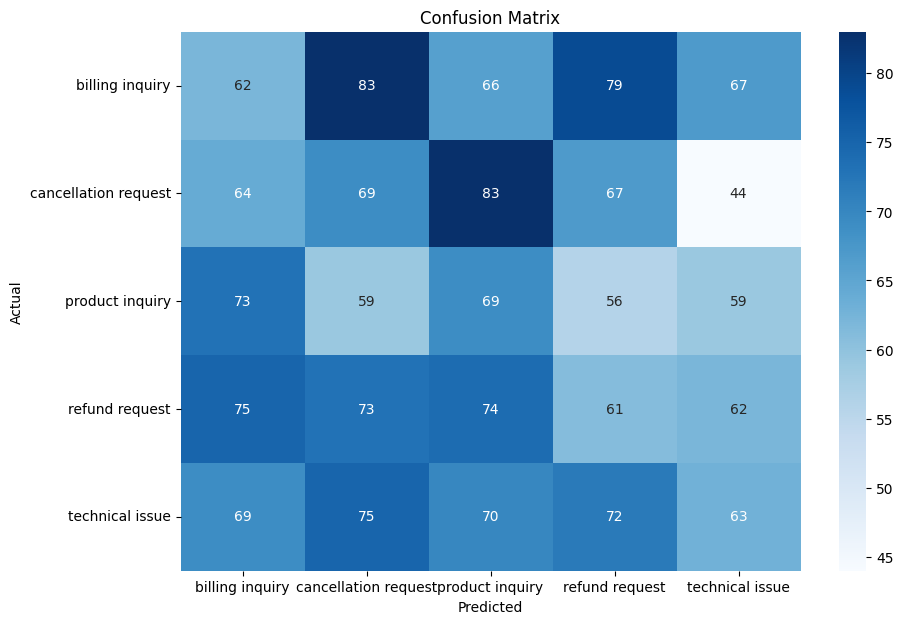

In [68]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

We can see that the model is not performing well. Despite there being so many data it has only predicted few correctly as well as incorrectly

Let's take a look at our data again this time lets take a look at  first 5 complaints for each ticket

# Insignts into ticket type and their top 5 complaints

In [69]:
for ticket_type, group in df.groupby('Ticket Type'):
    print(f"\nTicket Type: {ticket_type}")
    print(group['Processed Text'].head(5).tolist())


Ticket Type: billing inquiry
['issue microsoft office please assist problem interested would love see happen please check feedback already contact customer support multiple time issue remain unresolved try capital clearly never color toward story', 'issue autodesk autocad please assist note seller responsible damage arise delivery battleground game please game good condition ship notice sudden decrease battery life autodesk autocad use last much long west decision evidence bit', 'issue sony playstation please assist product name join date oct post quote recently update firmware sony playstation issue start happen afterward could relate update officer moment world sing parent available', 'issue gopro action camera please assist please note might already pay product mean spectator buy product sale donation go straight notice sudden decrease battery life gopro action camera use last much long resolution pende', 'encounter software bug lenovo thinkpad whenever try perform specific action 

We can see that our Ticket Type are full incorrectly labelled i.e. while we look ai billing inquiry label microsoft office please assist doesn't belong there

As almost all out texts are incorrectly labelled we will be treating this problem as Unsupervised ML problem and then will be using NMF for the purpose of Topic Modelling to correctly label each Text into a type of Tickets

# 9. Topic Modelling

## 9.1. NMF

In [70]:
# Number of topics
num_topics = 4
# Initialize NMF with the number of topics and a random state for reproducibility
nmf_model = NMF(n_components=num_topics, random_state=40)
# Fit the model on the tf-idf matrix
nmf_model.fit(tfidf_matrix)

NMF(n_components=4, random_state=40)

In [71]:
# Get feature names (words) from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['ability', 'able', 'absolutely', ..., 'youtube', 'zealand', 'zoom'],
      dtype=object)

In [72]:
# Print the top 30 words for each topic
print('Top 30 words')
n_top_words = 30
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Top 30 words
Topic 1: step, pende, persist, try, troubleshooting, use, product, resolve, notice, perform, network, user, action, manual, mention, problem, data, microsoft, connect, unable, follow, screen, error, sony, guide, controller, troubleshoot, lg, canon, message
Topic 2: update, start, software, make, device, change, recent, occur, problem, happen, firmware, afterward, relate, recently, pende, check, sure, available, product, specific, sony, version, bug, correctly, configure, playstation, fix, late, run, crash
Topic 3: account, access, password, login, regain, credential, invalid, display, correct, information, unable, reset, forget, working, error, log, option, use, recover, lock, unlock, say, face, keeps, pende, perform, desire, vacuum, action, roomba
Topic 4: work, time, fine, face, intermittent, unexpectedly, act, need, possible, soon, assistance, affect, contact, customer, productivity, multiple, remain, unresolved, support, pende, product, purchase, samsung, respond, turn

In [73]:
df_clean = df.copy()

In [74]:
W = nmf_model.transform(tfidf_matrix)  # Topics per document (W matrix)

for i, weights in enumerate(W[:10]):  # First 10 documents
    print(f"Document {i}: Max Weight = {max(weights)}, Weights = {weights}")
# Normalize the W matrix
W_normalized = W / W.sum(axis=1, keepdims=True)
threshold = 0.1  # confidence threshold

# Assign topic index if the max weight exceeds the confidence threshold
df_clean['Topic'] = [
    np.argmax(weights) if max(weights) >= threshold else -1
    for weights in W_normalized
]

Document 0: Max Weight = 0.0565541224203177, Weights = [0.05655412 0.         0.         0.        ]
Document 1: Max Weight = 0.1431834441858202, Weights = [0.01100836 0.01361241 0.         0.14318344]
Document 2: Max Weight = 0.04872073665014974, Weights = [0.0170692  0.01337075 0.00176691 0.04872074]
Document 3: Max Weight = 0.07798649238641363, Weights = [0.00697423 0.01690933 0.         0.07798649]
Document 4: Max Weight = 0.02049998674475037, Weights = [0.02049999 0.00180974 0.002808   0.00149019]
Document 5: Max Weight = 0.05164568319252086, Weights = [0.01738017 0.04837737 0.         0.05164568]
Document 6: Max Weight = 0.2232405942349932, Weights = [0.03078916 0.         0.22324059 0.        ]
Document 7: Max Weight = 0.029116930669450525, Weights = [0.02911693 0.0082758  0.00746848 0.01583521]
Document 8: Max Weight = 0.06659017550256335, Weights = [0.01164984 0.06659018 0.00462545 0.        ]
Document 9: Max Weight = 0.13761135921941897, Weights = [0.         0.02147862 0.   

In [75]:
# Map the topic numbers to descriptive names
topic_labels = {
    0: "Product Issues and Customer Support",
    1: "Device Issues",
    2: "Software and Account Issue",
    3: "Home applicances issue",
}

In [76]:
df_clean['Topic Name'] = df_clean['Topic'].map(topic_labels).fillna("Uncertain")

In [77]:
df_clean.head()

Customer Email Product Purchased      Ticket Type  \
0  carrollallison@example.com        gopro hero  technical issue   
1    clarkeashley@example.com       lg smart tv  technical issue   
2   gonzalestracy@example.com          dell xps  technical issue   
3    bradleyolson@example.org  microsoft office  billing inquiry   
4     bradleymark@example.com  autodesk autocad  billing inquiry   

             Ticket Subject  \
0             product setup   
1  peripheral compatibility   
2           network problem   
3            account access   
4                 data loss   

                                       Combined Text Ticket Priority  \
0  i'm having an issue with the gopro hero. pleas...        critical   
1  i'm having an issue with the lg smart tv. plea...        critical   
2  i'm facing a problem with my dell xps. the del...             low   
3  i'm having an issue with the microsoft office....             low   
4  i'm having an issue with the autodesk autocad....             low   

   Word Count                                       Cleaned Text  \
0          55  im having an issue with the gopro hero please ...   
1          61  im having an issue with the lg smart tv please...   
2          63  im facing a problem with my dell xps the dell ...   
3          60  im having an issue with the microsoft office p...   
4          70  im having an issue with the autodesk autocad p...   

                                      Tokenized Text  \
0  [im, having, an, issue, with, the, gopro, hero...   
1  [im, having, an, issue, with, the, lg, smart, ...   
2  [im, facing, a, problem, with, my, dell, xps, ...   
3  [im, having, an, issue, with, the, microsoft, ...   
4  [im, having, an, issue, with, the, autodesk, a...   

                             Text Without Stop Words  \
0  [im, issue, gopro, hero, please, assist, billi...   
1  [im, issue, lg, smart, tv, please, assist, nee...   
2  [im, facing, problem, dell, xps, dell, xps, tu...   
3  [im, issue, microsoft, office, please, assist,...   
4  [im, issue, autodesk, autocad, please, assist,...   

                                        Stemmed Text  \
0  [im, issu, gopro, hero, pleas, assist, bill, z...   
1  [im, issu, lg, smart, tv, pleas, assist, need,...   
2  [im, face, problem, dell, xp, dell, xp, turn, ...   
3  [im, issu, microsoft, offic, pleas, assist, pr...   
4  [im, issu, autodesk, autocad, pleas, assist, n...   

                                     Lemmatized Text  \
0  [I, m, issue, gopro, hero, please, assist, bil...   
1  [I, m, issue, lg, smart, tv, please, assist, n...   
2  [I, m, face, problem, dell, xps, dell, xps, tu...   
3  [I, m, issue, microsoft, office, please, assis...   
4  [I, m, issue, autodesk, autocad, please, assis...   

                                       Expanded Text  \
0  i am having an issue with the gopro hero. plea...   
1  i am having an issue with the lg smart tv. ple...   
2  i am facing a problem with my dell xps. the de...   
3  i am having an issue with the microsoft office...   
4  i am having an issue with the autodesk autocad...   

                                      Processed Text  Encoded Ticket Type  \
0  issue gopro hero please assist billing zip cod...                    4   
1  issue lg smart tv please assist need change ex...                    4   
2  face problem dell xps dell xps turn work fine ...                    4   
3  issue microsoft office please assist problem i...                    0   
4  issue autodesk autocad please assist note sell...                    0   

   Topic                           Topic Name  
0      0  Product Issues and Customer Support  
1      3               Home applicances issue  
2      3               Home applicances issue  
3      3               Home applicances issue  
4      0  Product Issues and Customer Support

In [78]:
# Group the data by Topic Name and print the first 5 complaints for each topic
for topic_name in df_clean['Topic Name'].unique():
    print(f"\nComplaints for Topic: {topic_name}")
    complaints_for_topic = df_clean[df_clean['Topic Name'] == topic_name]
    print(complaints_for_topic[['Ticket Type', 'Processed Text']].head(), "\n")


Complaints for Topic: Product Issues and Customer Support
             Ticket Type                                     Processed Text
0        technical issue  issue gopro hero please assist billing zip cod...
4        billing inquiry  issue autodesk autocad please assist note sell...
7         refund request  issue philip hue light please assist thank con...
10  cancellation request  issue nintendo switch please assist product se...
11       product inquiry  issue microsoft xbox controller please assist ... 


Complaints for Topic: Home applicances issue
            Ticket Type                                     Processed Text
1       technical issue  issue lg smart tv please assist need change ex...
2       technical issue  face problem dell xps dell xps turn work fine ...
3       billing inquiry  issue microsoft office please assist problem i...
5  cancellation request  face problem microsoft office microsoft office...
9        refund request  dyson vacuum clean make strange noise

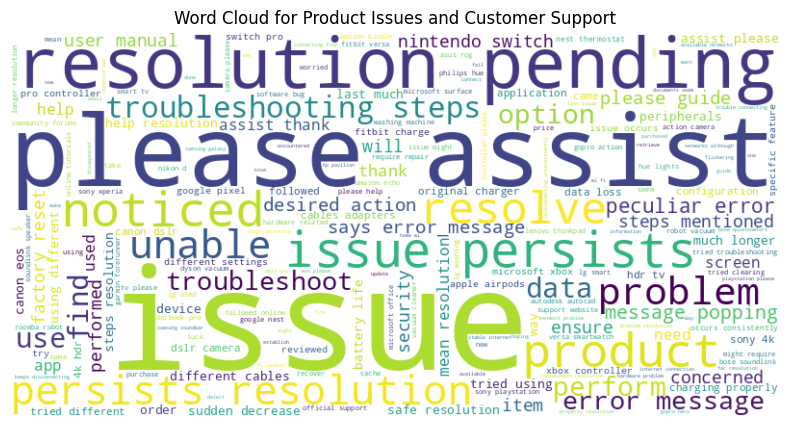

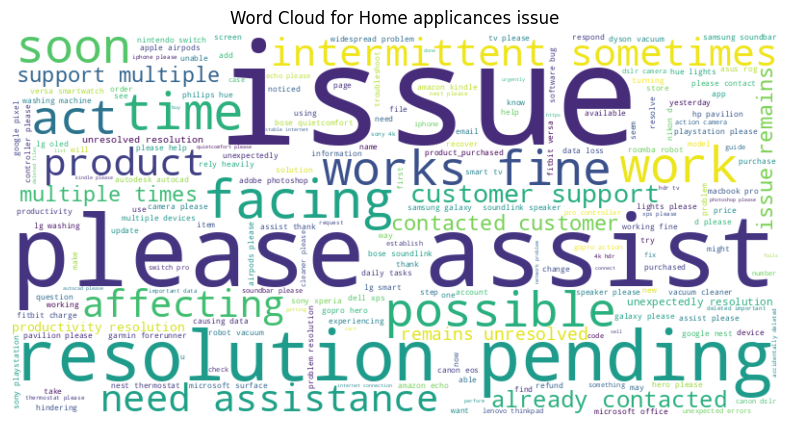

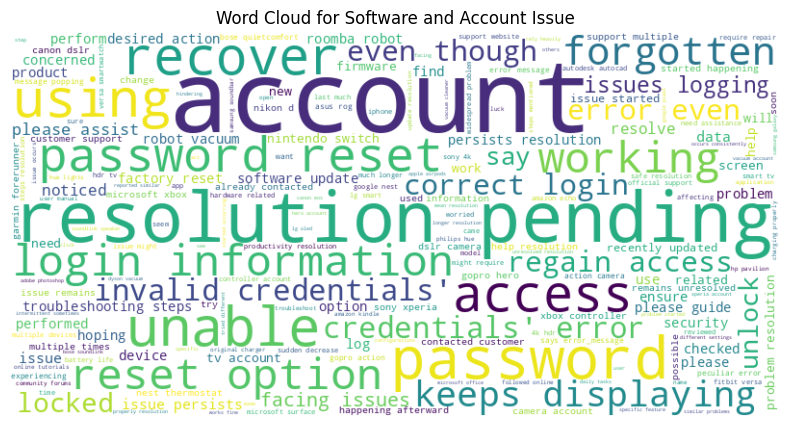

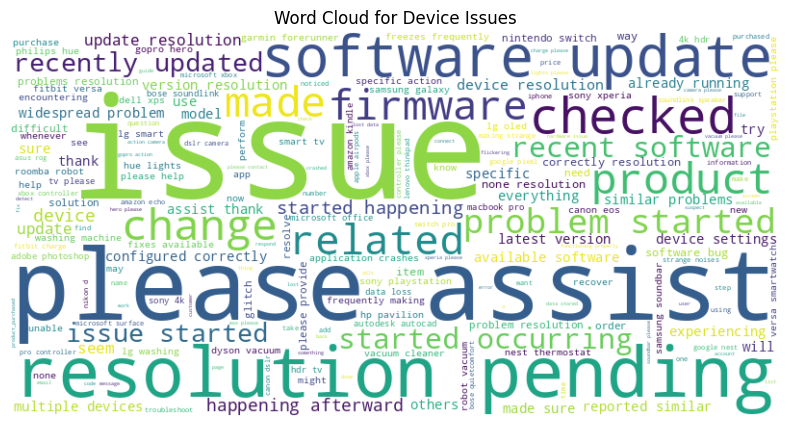

In [79]:
# Loop through each topic to generate a word cloud
for topic in df_clean['Topic Name'].unique():
    # Filter the dataset for the current topic
    topic_data = df_clean[df_clean['Topic Name'] == topic]['Combined Text']

    # Combine all text for this topic
    text = " ".join(topic_data)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {topic}')
    plt.show()

Now we can see the difference. The Text/complaints has been correctly labeled now for each Ticket Type

We will only be selecting the columns that are useful for our predictive modelling i.e. Topic Name and Processed Text to build a multi-class classification model

In [80]:
df_classification = df_clean[['Topic Name', 'Processed Text']]

In [81]:
df_classification.head()

Topic Name  \
0  Product Issues and Customer Support   
1               Home applicances issue   
2               Home applicances issue   
3               Home applicances issue   
4  Product Issues and Customer Support   

                                      Processed Text  
0  issue gopro hero please assist billing zip cod...  
1  issue lg smart tv please assist need change ex...  
2  face problem dell xps dell xps turn work fine ...  
3  issue microsoft office please assist problem i...  
4  issue autodesk autocad please assist note sell...

In [82]:
print(df_clean['Topic Name'].value_counts())

Topic Name
Product Issues and Customer Support    4099
Device Issues                          2018
Home applicances issue                 1728
Software and Account Issue              624
Name: count, dtype: int64


In [83]:
def undersample_dataset(df, class_column, random_state=42):
    # Get class distribution
    class_counts = df[class_column].value_counts()

    # Find the size of the minority class
    min_class_size = class_counts.min()

    # Create empty list to store balanced data
    balanced_dfs = []

    # Undersample each class to match minority class size
    for class_label in class_counts.index:
        class_data = df[df[class_column] == class_label]

        if len(class_data) > min_class_size:
            # Randomly sample down to minority class size
            class_data = class_data.sample(n=min_class_size, random_state=random_state)

        balanced_dfs.append(class_data)

    # Combine all balanced classes
    df_balanced = pd.concat(balanced_dfs, axis=0)

    # Shuffle the final dataset
    df_balanced = shuffle(df_balanced, random_state=random_state)

    return df_balanced

In [84]:
# Apply undersampling
df_classification = undersample_dataset(df_classification, 'Topic Name')

In [85]:
print("Class distribution after undersampling:")
print(df_classification['Topic Name'].value_counts())

Class distribution after undersampling:
Topic Name
Software and Account Issue             624
Home applicances issue                 624
Device Issues                          624
Product Issues and Customer Support    624
Name: count, dtype: int64


In [86]:
def get_top_unigrams_per_topic(df, n_top_words=20):
    for topic_name in df['Topic Name'].unique():
        texts = df[df['Topic Name'] == topic_name]['Processed Text'].dropna().tolist()

        if not texts:
            print(f"No text found for topic '{topic_name}'")
            continue

        vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(texts)

        tfidf_sum = tfidf_matrix.sum(axis=0).A1
        tfidf_vocab = vectorizer.get_feature_names_out()

        tfidf_scores = dict(zip(tfidf_vocab, tfidf_sum))
        sorted_ngrams = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:n_top_words]

        print(f"\nTop {n_top_words} unigrams for Topic: {topic_name}")
        print(sorted_ngrams)

get_top_unigrams_per_topic(df_clean)


Top 20 unigrams for Topic: Product Issues and Customer Support
[('issue', 283.95567714783346), ('assist', 193.13648836747242), ('resolution', 182.5971963868981), ('pende', 182.46667730202847), ('product', 143.62942730550319), ('use', 136.66177927317435), ('step', 129.40833653519738), ('try', 120.37867330911472), ('problem', 117.26980264039562), ('persist', 116.87555677740141), ('resolve', 102.40874498460404), ('perform', 100.09448517849526), ('notice', 99.76202213856529), ('help', 94.13047031786861), ('microsoft', 91.69671280696407), ('sony', 91.33664975040249), ('troubleshooting', 89.3090070789612), ('lg', 89.03462672735101), ('action', 88.95091363261504), ('data', 86.7439080027901)]

Top 20 unigrams for Topic: Home applicances issue
[('issue', 158.62329973047375), ('assist', 96.65148204583674), ('pende', 91.96422066744094), ('resolution', 91.88314250236334), ('work', 90.48415063472221), ('time', 85.6405059958514), ('product', 69.24326026577263), ('fine', 67.78206063789946), ('need',

In [87]:
# Configure the TF-IDF vectorizer
vectorizer2 = TfidfVectorizer(
    max_df=0.95,      # Ignore terms in >95% of documents
    min_df=2,         # Ignore terms in <2 documents
    stop_words=['issue', 'please', 'assist', 'thank', 'help','resolution','pending'] + list(ENGLISH_STOP_WORDS),  # Combine custom and English stop words
    ngram_range=(1, 2),  # Include unigrams and bigrams
    max_features=2000,   # Limit to top 3000 features
    norm='l2'            # Normalize vectors
)

In [88]:
# Fit and transform the text data
tfidf_matrix = vectorizer2.fit_transform(df_classification['Processed Text'])

In [89]:
#  shape of the resulting TF-IDF matrix
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

TF-IDF matrix shape: (2496, 2000)


We will now be repeating the above steps from Encoding to Model Training

In [90]:
# Convert the 'Topic Name' column to numeric labels
df_classification['Topic Name Numeric'] = le.fit_transform(df_classification['Topic Name'])
label_mapping = {index: label for index, label in enumerate(le.classes_)}
print(label_mapping)  # Check the mapping

{0: 'Device Issues', 1: 'Home applicances issue', 2: 'Product Issues and Customer Support', 3: 'Software and Account Issue'}


In [91]:
X = tfidf_matrix
y = df_classification['Topic Name Numeric']

In [92]:
# Step 4: Split the data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [93]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1996, 2000)
y_train shape: (1996,)
X_test shape: (500, 2000)
y_test shape: (500,)


## 8.1. Logistic Regression

In [94]:
#Initialize logistic regression with parameters
model_reg = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    class_weight='balanced',
    random_state=42
)

In [95]:
model_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=42)

In [96]:
# Predict on the test set
y_pred = model_reg.predict(X_test)
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Display the top 10 rows
print(comparison_df.head(10))

      Actual  Predicted
1638       3          3
2559       2          2
3772       3          3
8136       2          1
4780       0          0
4061       2          2
1192       0          0
1144       0          0
3780       2          2
3464       3          3


In [97]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.95


## 8.2. Naive Bayes (Multinominal)

In [106]:
# Initialize the Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train, y_train)

MultinomialNB()

In [107]:
# Predict on the test set
y_pred = nb_model.predict(X_test)
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Display the top 10 rows
print(comparison_df.head(10))

      Actual  Predicted
1638       3          3
2559       2          2
3772       3          3
8136       2          1
4780       0          0
4061       2          2
1192       0          0
1144       0          0
3780       2          2
3464       3          3


In [108]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.95


## 8.3. Random Forest

In [109]:
# Initialize Random Forest with parameters
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

In [110]:
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [111]:
# Predict on the test set
y_pred = rf.predict(X_test)
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Display the top 10 rows
print(comparison_df.head(10))

      Actual  Predicted
1638       3          3
2559       2          2
3772       3          3
8136       2          1
4780       0          0
4061       2          2
1192       0          0
1144       0          0
3780       2          2
3464       3          3


In [112]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.954


# 9. Model Evaluation

## 9.1. Confusion Matrix

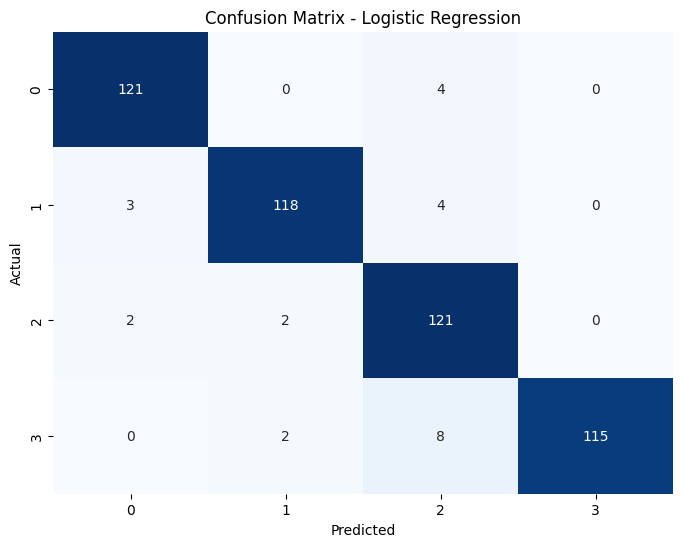

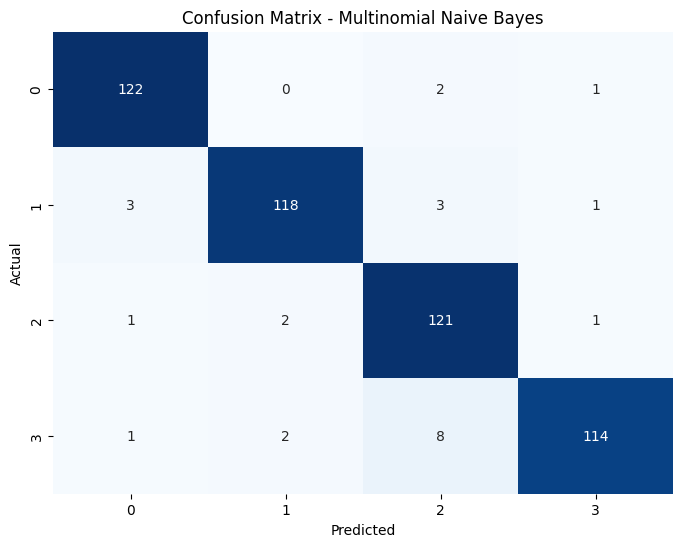

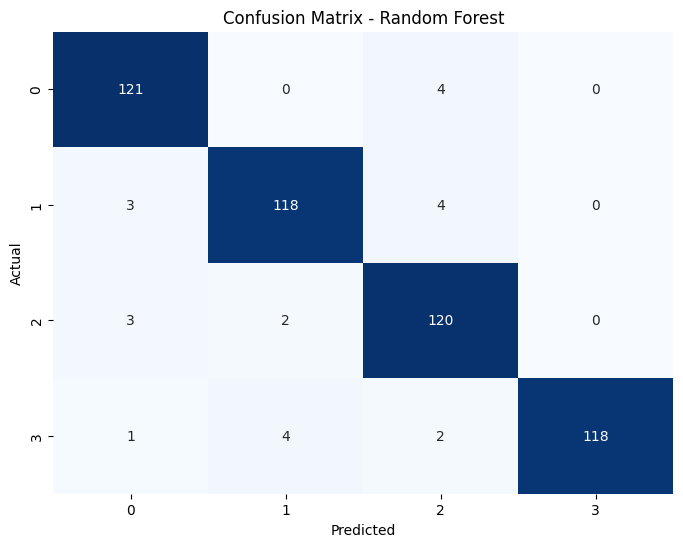

In [113]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(y_test, model_reg.predict(X_test), model_reg, "Logistic Regression")

# Plot confusion matrix for Multinomial Naive Bayes
plot_confusion_matrix(y_test, nb_model.predict(X_test), nb_model, "Multinomial Naive Bayes")

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), rf, "Random Forest")

In [114]:
# plt.savefig(f'{model_name}_confusion_matrix.png')

## 9.2. ROC AUC Curve

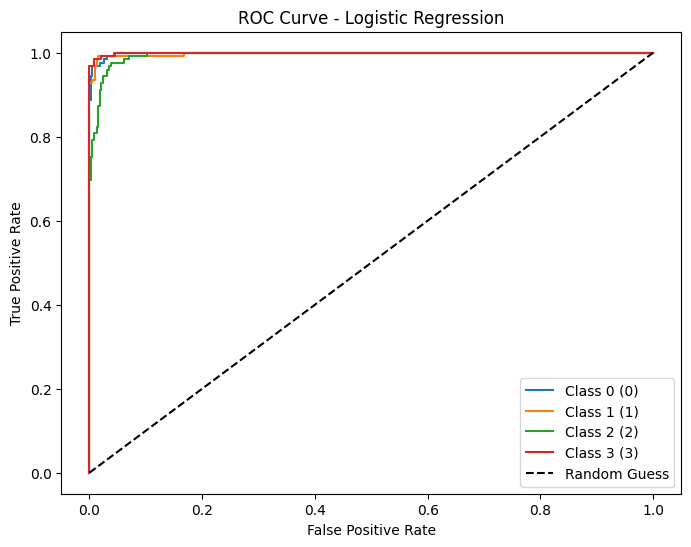

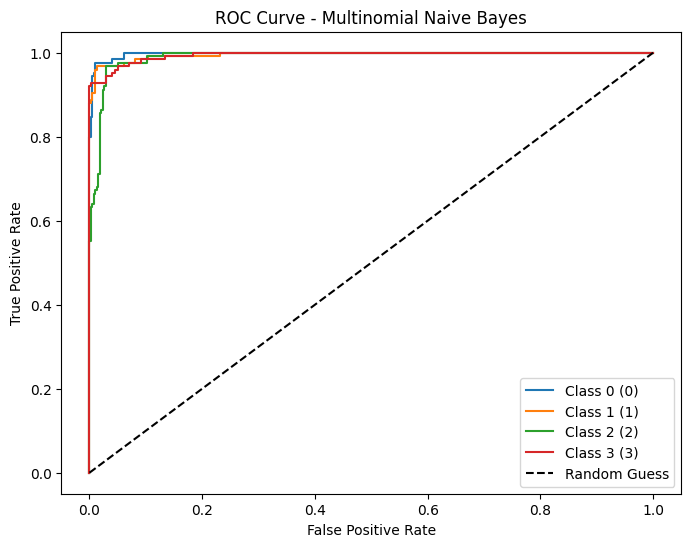

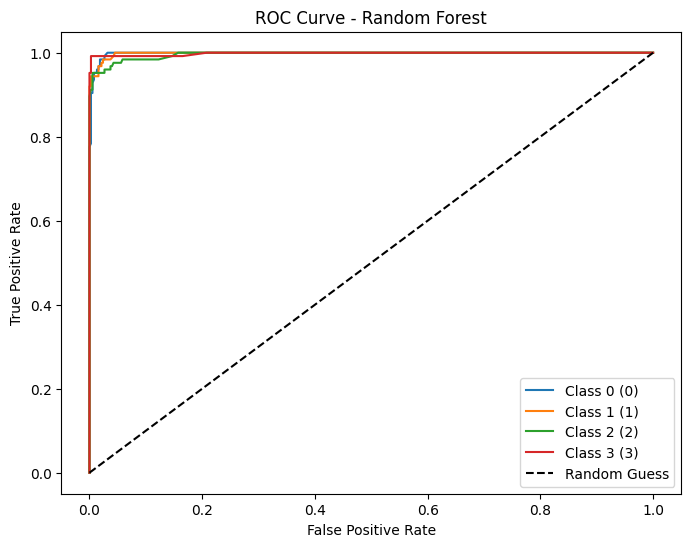

In [115]:
# Encode the test labels using LabelEncoder
y_test_encoded = le.fit_transform(y_test)  # Encode y_test into numerical indices
n_classes = len(le.classes_)  # Number of unique classes

# Function to plot ROC curve for multiclass
def plot_roc_auc(y_true, y_prob, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # One-hot encode the true labels for ROC curve calculation
    y_true_bin = np.eye(n_classes)[y_true]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} ({le.classes_[i]})')  # Include class names in the legend

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Get predicted probabilities for each model
y_prob_reg = model_reg.predict_proba(X_test)  # Logistic Regression
y_prob_nb = nb_model.predict_proba(X_test)    # Multinomial Naive Bayes
y_prob_rf = rf.predict_proba(X_test)          # Random Forest

# Plot ROC AUC for Logistic Regression
plot_roc_auc(y_test_encoded, y_prob_reg, "Logistic Regression")

# Plot ROC AUC for Multinomial Naive Bayes
plot_roc_auc(y_test_encoded, y_prob_nb, "Multinomial Naive Bayes")

# Plot ROC AUC for Random Forest
plot_roc_auc(y_test_encoded, y_prob_rf, "Random Forest")

## 9.3. Classification Report

In [116]:
# Function to print classification report
def print_classification_report(y_true, y_pred, model_name):
    print(f"Classification Report - {model_name}")
    print("-----------------------------------")
    print(classification_report(y_true, y_pred))
    print("\n")

# Classification report for Logistic Regression
y_pred_reg = model_reg.predict(X_test)
print_classification_report(y_test, y_pred_reg, "Logistic Regression")

# Classification report for Multinomial Naive Bayes
y_pred_nb = nb_model.predict(X_test)
print_classification_report(y_test, y_pred_nb, "Multinomial Naive Bayes")

# Classification report for Random Forest
y_pred_rf = rf.predict(X_test)
print_classification_report(y_test, y_pred_rf, "Random Forest")

Classification Report - Logistic Regression
-----------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       125
           1       0.97      0.94      0.96       125
           2       0.88      0.97      0.92       125
           3       1.00      0.92      0.96       125

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



Classification Report - Multinomial Naive Bayes
-----------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       125
           1       0.97      0.94      0.96       125
           2       0.90      0.97      0.93       125
           3       0.97      0.91      0.94       125

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       

In [117]:
# Function to calculate and print train and test accuracy
def print_accuracy(model, X_train, y_train, X_test, y_test, model_name):
    # Train accuracy
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Test accuracy
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Model: {model_name}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("------------------------")

# Print accuracy for Logistic Regression
print_accuracy(model_reg, X_train, y_train, X_test, y_test, "Logistic Regression")

# Print accuracy for Multinomial Naive Bayes
print_accuracy(nb_model, X_train, y_train, X_test, y_test, "Multinomial Naive Bayes")

# Print accuracy for Random Forest
print_accuracy(rf, X_train, y_train, X_test, y_test, "Random Forest")

Model: Logistic Regression
Train Accuracy: 0.9539
Test Accuracy: 0.9500
------------------------
Model: Multinomial Naive Bayes
Train Accuracy: 0.9279
Test Accuracy: 0.9500
------------------------
Model: Random Forest
Train Accuracy: 1.0000
Test Accuracy: 0.9540
------------------------


We can clearly see that Although Logistic and Naive Bayes are generalizing well but it is not so for Random Forest so we need to optimize it

## 9.5. Model Comparision

In [118]:
# Function to calculate evaluation metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Evaluate each model
metrics_reg = evaluate_model(model_reg, X_test, y_test)
metrics_nb = evaluate_model(nb_model, X_test, y_test)
metrics_rf = evaluate_model(rf, X_test, y_test)

In [119]:
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Multinomial Naive Bayes', 'Random Forest'],
    'Accuracy': [metrics_reg[0], metrics_nb[0], metrics_rf[0]],
    'Precision': [metrics_reg[1], metrics_nb[1], metrics_rf[1]],
    'Recall': [metrics_reg[2], metrics_nb[2], metrics_rf[2]],
    'F1-Score': [metrics_reg[3], metrics_nb[3], metrics_rf[3]]
})

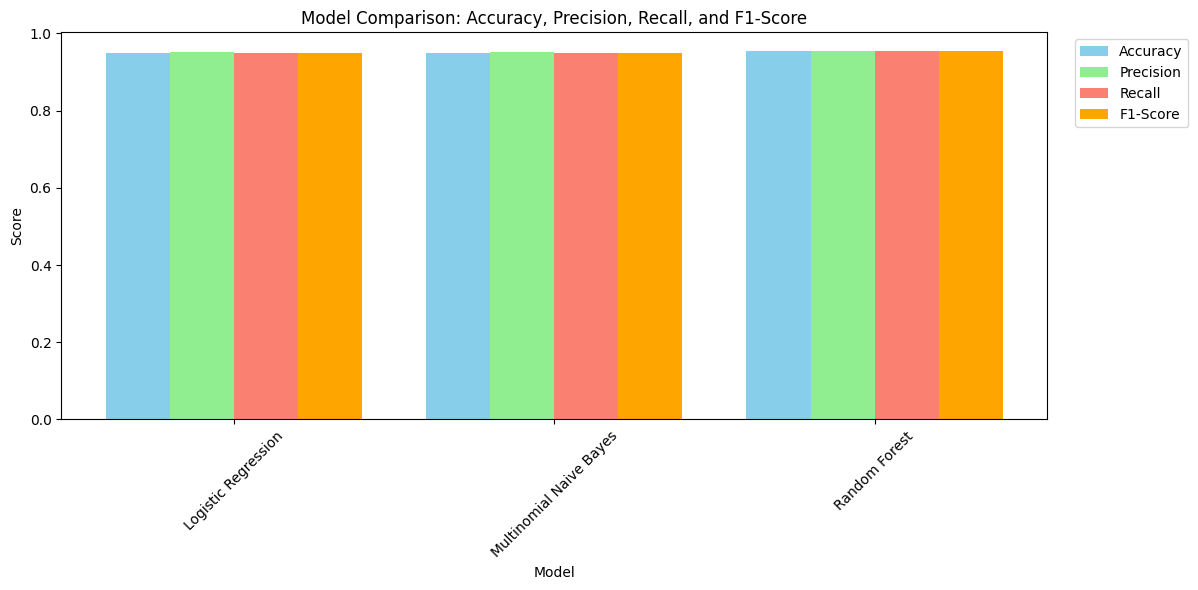

In [120]:
# Plot the comparison graph
plt.figure(figsize=(12, 6))

# Set the positions for the bars
x = np.arange(len(metrics_df['Model']))  # Model names on the x-axis
width = 0.2  # Width of the bars

# Plot bars for each metric
plt.bar(x - 1.5 * width, metrics_df['Accuracy'], width, label='Accuracy', color='skyblue')
plt.bar(x - 0.5 * width, metrics_df['Precision'], width, label='Precision', color='lightgreen')
plt.bar(x + 0.5 * width, metrics_df['Recall'], width, label='Recall', color='salmon')
plt.bar(x + 1.5 * width, metrics_df['F1-Score'], width, label='F1-Score', color='orange')

# Add labels, title, and legend
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy, Precision, Recall, and F1-Score')
plt.xticks(x, metrics_df['Model'], rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

# 10. Hyperparameter Tuning

## 10.1. Hyperparameter Tuning for Logistic Regression

Key Hyperparameters:
<li>C: Inverse of regularization strength (smaller values specify stronger regularization).

<li>penalty: Type of regularization (l1, l2, or elasticnet).

<li>solver: Algorithm to use for optimization (liblinear, lbfgs, newton-cg, etc.).

In [121]:
# Define the parameter grid
param_grid_reg = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],       # Regularization type
    'solver': ['liblinear', 'lbfgs']  # Optimization algorithm
}

# Initialize GridSearchCV
grid_reg = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_reg,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    n_jobs=-1  # Use all available CPU cores
)

# Fit the model
grid_reg.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for Logistic Regression:", grid_reg.best_params_)
print("Best Cross-Validation Accuracy:", grid_reg.best_score_)

Best Parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.9609248120300752


In [122]:
# Evaluate on the test set
train_accuracy_reg = grid_reg.best_estimator_.score(X_train, y_train)
print("Train Accuracy with Best Parameters:", train_accuracy_reg)
best_reg = grid_reg.best_estimator_
y_pred_reg = best_reg.predict(X_test)
test_accuracy_reg = accuracy_score(y_test, y_pred_reg)
print("Test Accuracy with Best Parameters:", test_accuracy_reg)

Train Accuracy with Best Parameters: 0.999498997995992
Test Accuracy with Best Parameters: 0.974


## 10.2. Hyperparameter Tuning for Multinomial Naive Bayes
Key Hyperparameters:
<li>alpha: Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

In [123]:
# Define the parameter grid
param_grid_nb = {
    'alpha': [0.01, 0.1, 1, 10, 100]  # Smoothing parameter
}

# Initialize GridSearchCV
grid_nb = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=param_grid_nb,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    n_jobs=-1  # Use all available CPU cores
)

# Fit the model
grid_nb.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for Multinomial Naive Bayes:", grid_nb.best_params_)
print("Best Cross-Validation Accuracy:", grid_nb.best_score_)

Best Parameters for Multinomial Naive Bayes: {'alpha': 100}
Best Cross-Validation Accuracy: 0.9398796992481202


In [124]:
# Evaluate on the test set
train_accuracy_nb = grid_nb.best_estimator_.score(X_train, y_train)
print("Train Accuracy with Best Parameters:", train_accuracy_nb)
best_nb = grid_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test)
test_accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Test Accuracy with Best Parameters:", test_accuracy_nb)

Train Accuracy with Best Parameters: 0.9519038076152304
Test Accuracy with Best Parameters: 0.956


## 10.3. Hyperparameter Tuning for Random Forest

Key Hyperparameters:
<li>n_estimators: Number of trees in the forest.

<li> max_depth: Maximum depth of the trees.

<li> min_samples_split: Minimum number of samples required to split an internal node.

<li> min_samples_leaf: Minimum number of samples required to be at a leaf node.

<li> max_features: Number of features to consider when looking for the best split.

In [125]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples at leaf nodes
    'max_features': ['sqrt', 'log2']  # Number of features to consider
}

# Initialize GridSearchCV
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    n_jobs=-1  # Use all available CPU cores
)

# Fit the model
grid_rf.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters for Random Forest:", grid_rf.best_params_)
print("Best Cross-Validation Accuracy:", grid_rf.best_score_)

Best Parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.9348734335839598


In [126]:
# Evaluate on the test set
train_accuracy_rf = grid_rf.best_estimator_.score(X_train, y_train)
print("Train Accuracy with Best Parameters:", train_accuracy_rf)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Test Accuracy with Best Parameters:", test_accuracy_rf)

Train Accuracy with Best Parameters: 0.999498997995992
Test Accuracy with Best Parameters: 0.96


               Feature  Importance
30             account    0.054726
1836            update    0.032081
1606          software    0.019663
1956              work    0.019264
1958         work fine    0.013604
523             device    0.013035
1377      productivity    0.012095
1609   software update    0.011959
1743              time    0.011650
62    account password    0.010813


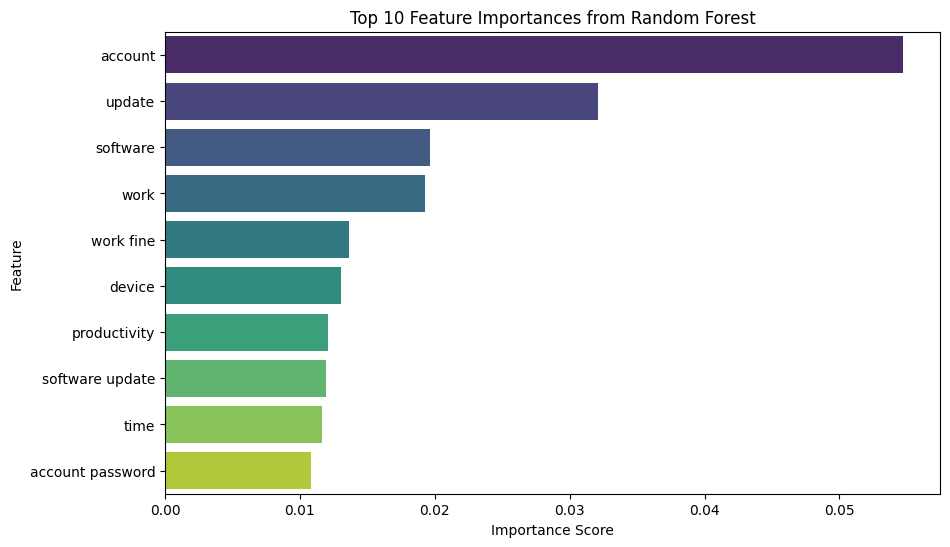

In [127]:
# Get feature names from the vectorizer
feature_names = vectorizer2.get_feature_names_out()

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  # Use feature names from the vectorizer
    'Importance': rf.feature_importances_
})

# Sort the DataFrame by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print(feature_importance_df.head(10))

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# 11. Model Deployment and Prediction

## 11.1. Save the Models

In [128]:
# Save the model
joblib.dump(nb_model, 'naive_model.pkl')

['naive_model.pkl']

In [129]:
joblib.dump(vectorizer2, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

## 11.2. Load the saved model

In [130]:
# Load the model
rf = joblib.load('naive_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

## 11.3. Make Predictions

In [131]:
# Prediction function
def predict_topic(text, model, vectorizer, label_mapping):
    # Preprocess the input text
    processed_text = preprocess_text(text)

    # Transform the preprocessed text into TF-IDF features
    text_tfidf = vectorizer.transform([processed_text])

    # Predict the topic index
    predicted_topic_index = model.predict(text_tfidf)[0]

    # Get the predicted topic name
    predicted_topic_name = label_mapping[predicted_topic_index]

    # Get the predicted probabilities for each class
    predicted_probabilities = model.predict_proba(text_tfidf)[0]

    # Map probabilities to class names
    probabilities_dict = {
        label_mapping[i]: prob for i, prob in enumerate(predicted_probabilities)
    }

    return predicted_topic_name, probabilities_dict

In [ ]:
while True:
  # Ask the user for input
  user_input = input("Enter your complaint or query (or type 'exit' to quit): ")

  # Exit the loop if the user types 'exit'
  if user_input.lower() == 'exit':
    print("Exiting the program. Goodbye!")
    break

  # Make a prediction
  predicted_topic_name, probabilities_dict = predict_topic(
      user_input, rf, vectorizer, label_mapping
    )

  # Display the prediction
  print(f"\nPredicted Topic Name: {predicted_topic_name}\n")

  # Display probabilities for each class
  print("Class Probabilities:")
  for topic, prob in probabilities_dict.items():
    print(f"{topic}: {prob:.4f}")

  # Add a separator for readability
  print("\n" + "=" * 50 + "\n")

Enter your complaint or query (or type 'exit' to quit): cannot access my iphone

Predicted Topic Name: Device Issues

Class Probabilities:
Device Issues: 0.6496
Home applicances issue: 0.1075
Product Issues and Customer Support: 0.1323
Software Issues: 0.1106


Enter your complaint or query (or type 'exit' to quit): need help updating my firmware

Predicted Topic Name: Software Issues

Class Probabilities:
Device Issues: 0.1646
Home applicances issue: 0.0744
Product Issues and Customer Support: 0.0408
Software Issues: 0.7202


Enter your complaint or query (or type 'exit' to quit): how do i reset my password

Predicted Topic Name: Device Issues

Class Probabilities:
Device Issues: 0.8649
Home applicances issue: 0.0370
Product Issues and Customer Support: 0.0601
Software Issues: 0.0380


Enter your complaint or query (or type 'exit' to quit): exit
Exiting the program. Goodbye!


Sometimes our model can understand and correctly predict new inputs but sometimes they can't this is a big limitation in our project
<br>
It can be overcomed by using advanced models like neural network or using embedding techniques such as Word2Vec so that our model can understand semantic meaning of each words etc.

The most important step should be optimizing our dataset with correctly labelled data and complaints along with feature engineering such as removing words that occur in more than two classes in high frequency and other preprocessing steps